# Heat equation - Retrieving operator through ODE solving

In [3]:
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DifferentialEquations
using Plots
using GalacticOptim
using MLUtils
using IterTools: ncycle
using LinearAlgebra
using DiffEqSensitivity
using Zygote
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/examples/heat/heat_training.jl")

Main.HeatTraining

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [4]:
t_max = 1.;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

typ = 3;
d = 1.;
k = 1.;
kappa = 0.005;
L = x_max - x_min
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

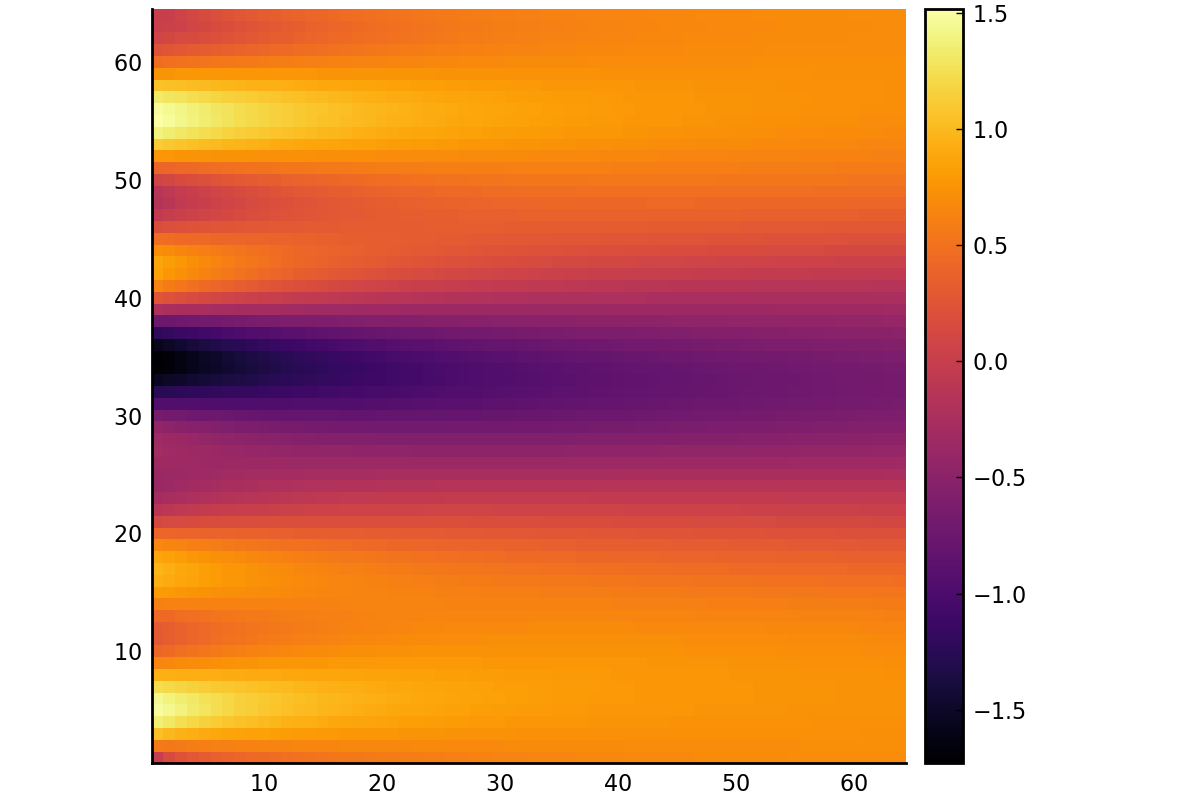

In [5]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.heat_analytical_init(t, x, n, c, kappa);
t, u = Equations.get_heat_fft(t, dx, x_n, kappa, u0[1, :]);
GraphicTools.show_state(u, "")

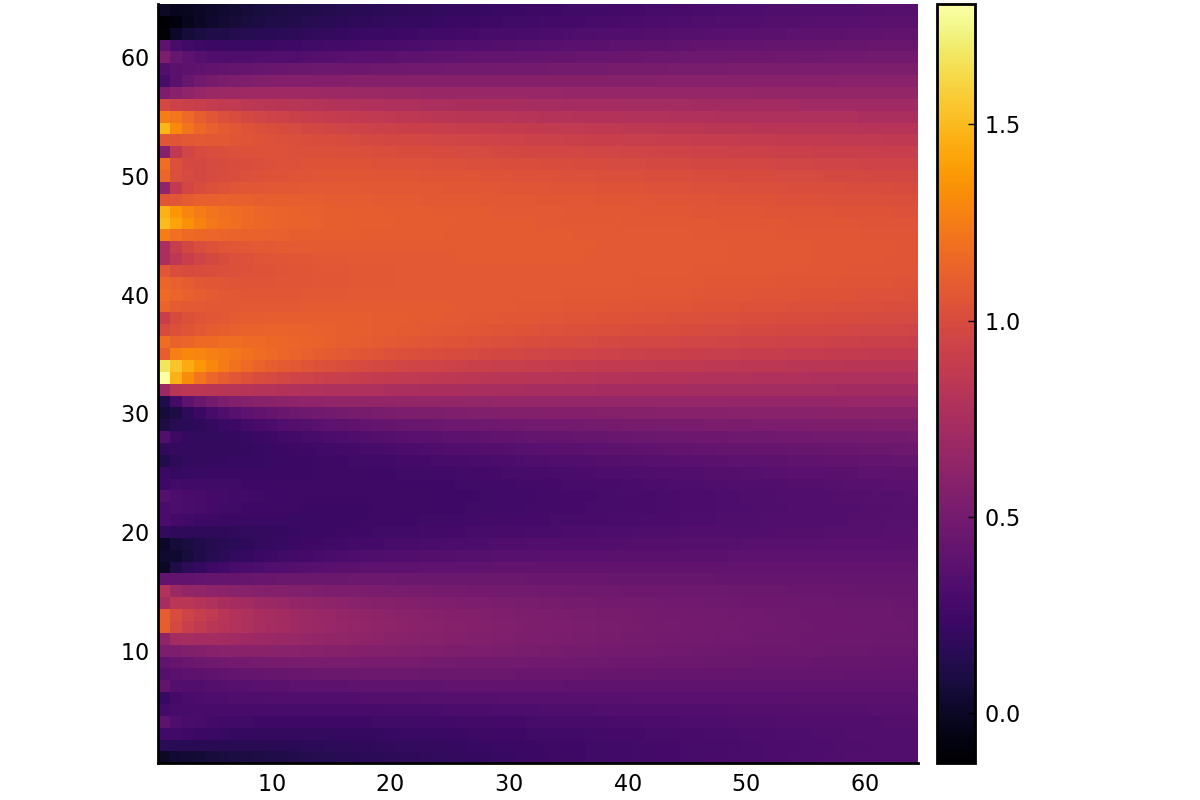

In [6]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 3, kappa)
GraphicTools.show_state(u_a, "")

## Generate dataset

In [7]:
# dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 256, 3, kappa, "./src/dataset/odesolver_analytical_heat_training_set.jld2", "training_set");
# hand_dataset = Generator.read_dataset("./src/dataset/hand_analytical_heat_training_set.jld2")["training_set"];
analytic_dataset = Generator.read_dataset("./src/dataset/odesolver_analytical_heat_training_set.jld2")["training_set"];
# high_dataset = Generator.read_dataset("./src/examples/heat/heat_high_dim_training_set.jld2")["training_set"];

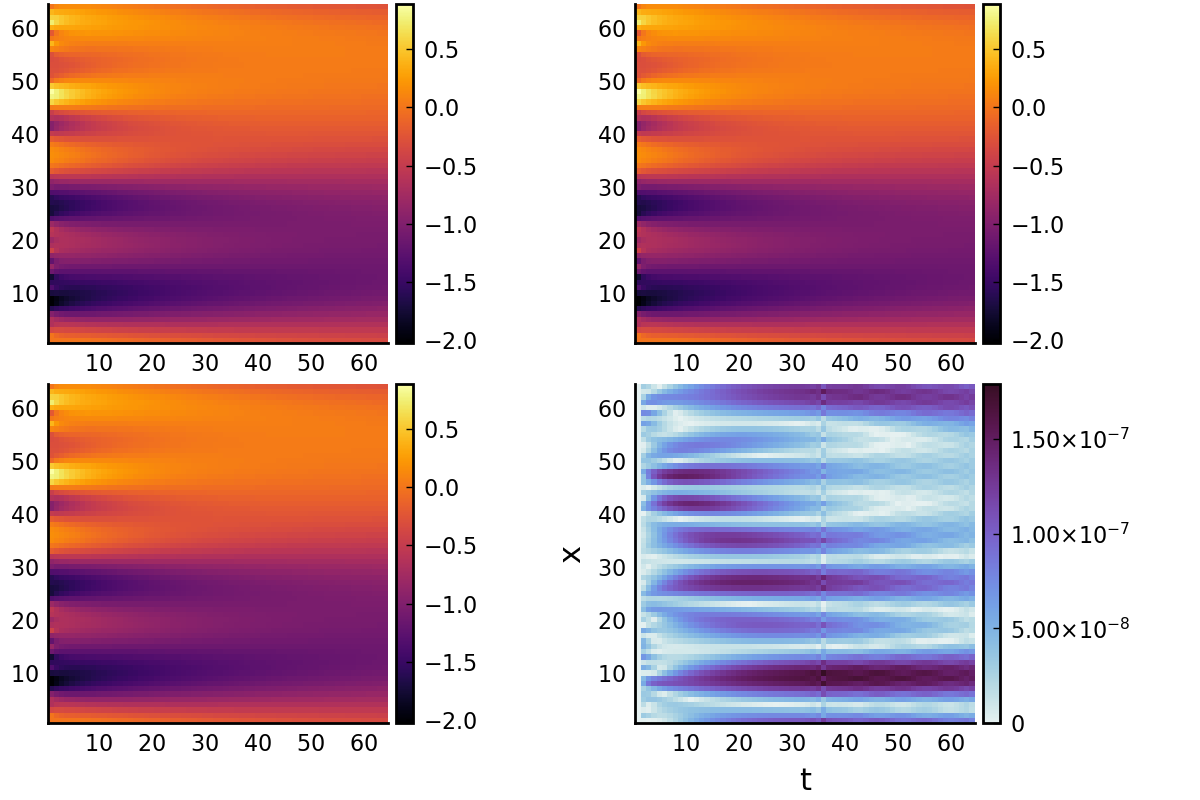

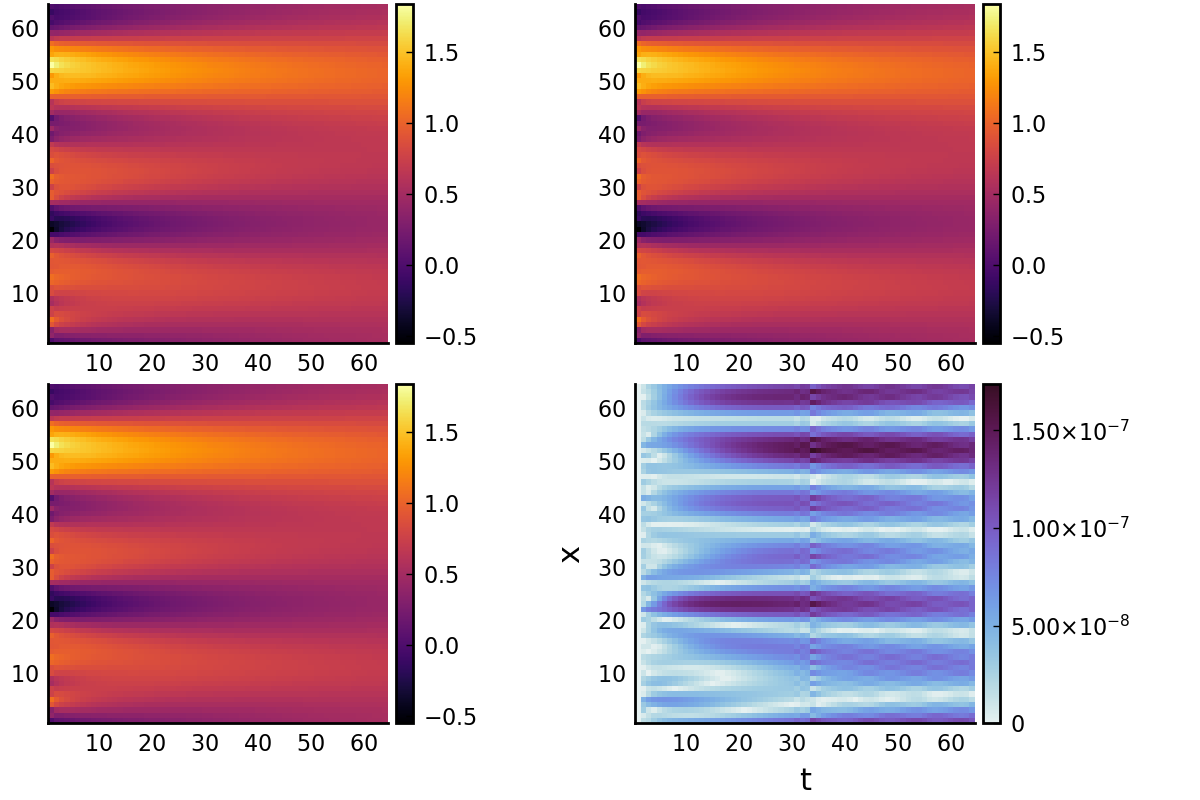

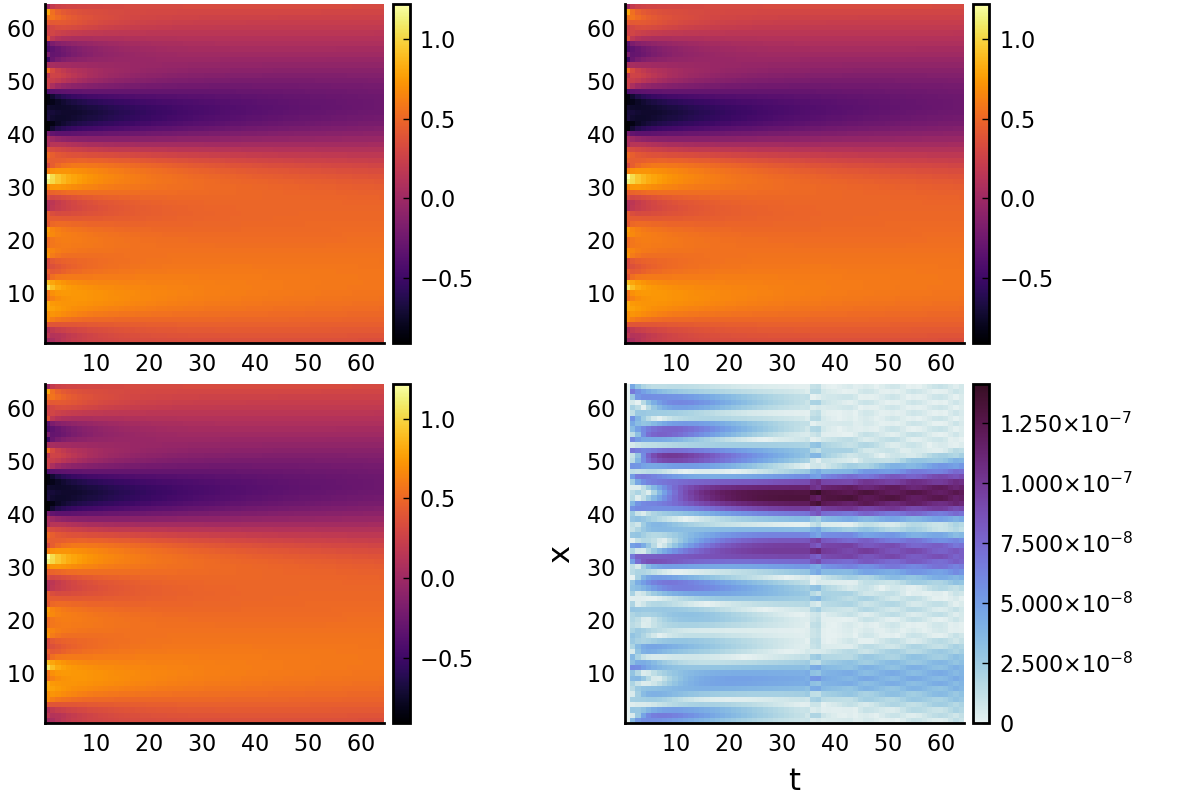

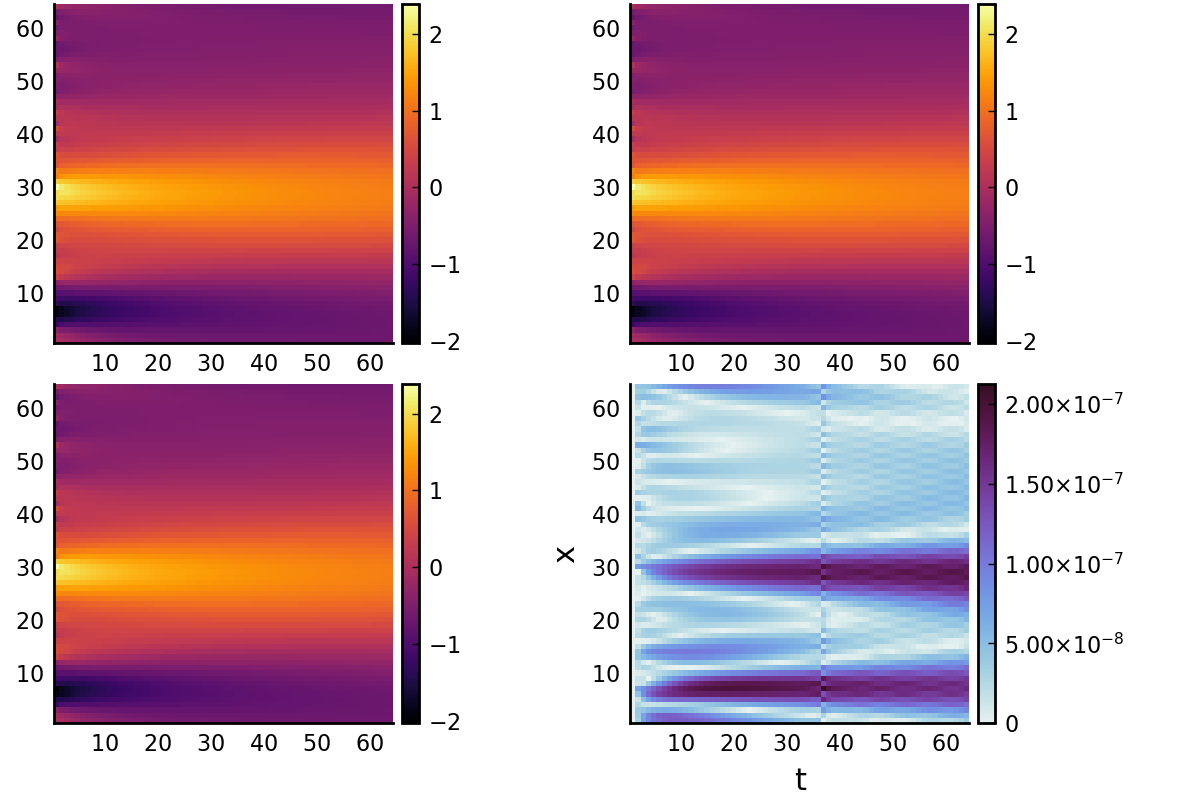

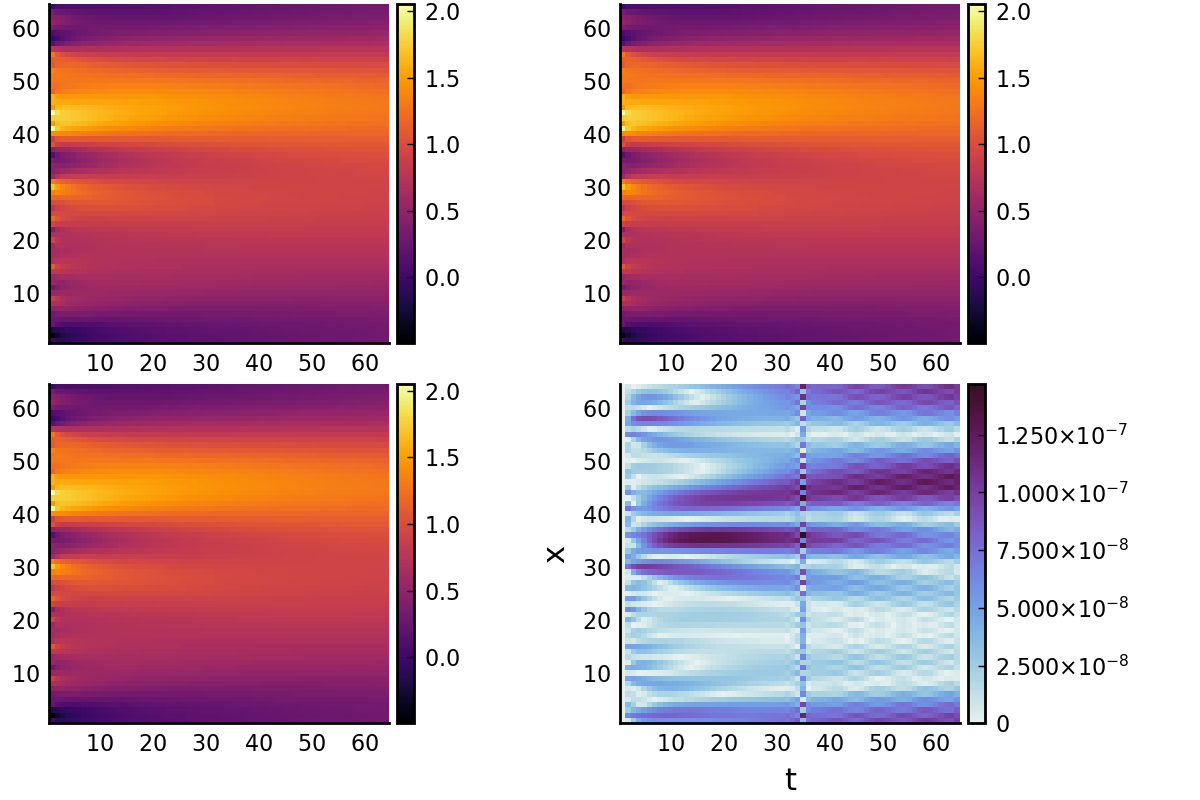

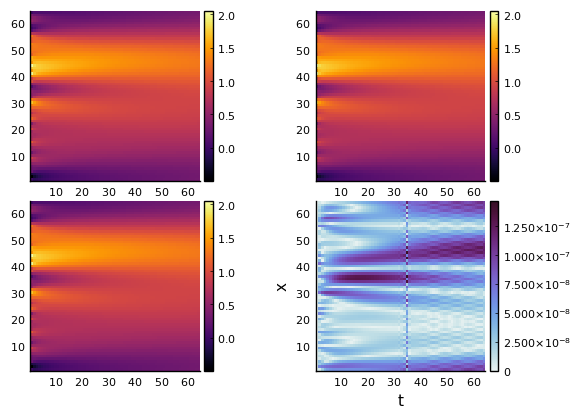

In [8]:
function check_training_dataset(dataset)
    for i in range(1, 5, step=1)
        a, b, _, d = dataset[i];
        _, c = Equations.get_heat_fft(a, dx, x_n, kappa, b[:, 1]);
        
        display(
            plot(
            GraphicTools.show_state(d, ""),
            GraphicTools.show_state(b, ""),
            GraphicTools.show_state(c, ""),
            GraphicTools.show_err(c, b, "", "t", "x");
            layout = (2, 2),
            );
        );
    end
end

check_training_dataset(analytic_dataset)

---
# Operator reconstruction 

In [10]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, x_n, t_n, typ, kappa);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t);
    u_pred = prob_neuralode(u0, res);

    display(
        plot(
            GraphicTools.show_state(u, ""),
            GraphicTools.show_state(hcat(u_pred.u...), ""),
            GraphicTools.show_err(hcat(u_pred.u...), u, "");
            layout = (1, 3),
        )
    )
end

check_result (generic function with 1 method)

In [11]:
function training(model, epochs, dataset, batch_size, ratio, noise=0., reg=0., cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(false)
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end
  model = model |> device;

  opt = Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8);
  ltrain = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, batch_size, ratio, false);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
      tspan = (t[1], t[end]);
      _prob = remake(prob; u0=x, p=p, tspan=tspan);
      Array(solve(_prob, Tsit5(), u0=x, p=p, saveat=t));
  end

  function loss(x, y, t)
      u_pred = predict_neural_ode(x, t[1]);
      ŷ = Reg.gaussian_augment(u_pred, noise);
      l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) + Reg.l2(p, reg); # 1e-5
      return l;
  end

  function traincb()
      ltrain = 0;
      for (x, y, t) in train_loader
           ltrain += loss(x, y, t);
      end
      ltrain /= (train_loader.nobs / train_loader.batchsize);
      @show(ltrain);
  end


  function val_loss(x, y, t)
      u_pred = predict_neural_ode(x, t[1]);
      ŷ = u_pred
      l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
      return l;
  end

  function evalcb()
      lval = 0;
      for (x, y, t) in val_loader
           lval += val_loss(x, y, t);
      end
      lval /= (val_loader.nobs / val_loader.batchsize);
      @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
        Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
        trigger() && break;
  end

  return re(p), p
end

training (generic function with 4 methods)

In [34]:
function main()
  batch_size = 32;
  epochs = 200;

  data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
  model = Models.LinearModel(x_n);
  K, p = training(model, epochs, data, batch_size, 0.9);
  # @save "HeatLinearModel.bson" K
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[11]:8
┌ Info: Loading dataset
└ @ Main In[11]:16
┌ Info: Training on CPU
└ @ Main.ProcessingTools /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/utils/processing_tools.jl:70
┌ Info: Building model
└ @ Main In[11]:19
┌ Info: Train
└ @ Main In[11]:64
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13751073346415782
lval = 0.00035912220584719917
ltrain = 0.11346843192646633
lval = 0.00020083503381356624
ltrain = 0.10358748880959703
lval = 0.00014359923220499222
ltrain = 0.10235085339043307
lval = 0.00017402847538312214


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10082253309672495
lval = 0.0001933381374246266
ltrain = 0.09530995752289345
lval = 0.0001684870648043676
ltrain = 0.08641059348169432
lval = 0.00011639479509726497
ltrain = 0.08244917318701173
lval = 0.00010985643120649079


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08151912891366331
lval = 0.0001312130990677812
ltrain = 0.08163653296301908
lval = 0.00015774003532027347
ltrain = 0.07852965208292173
lval = 0.00014838403288593003
ltrain = 0.0751356263464216
lval = 0.00012648611104263167


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07289329289806369
lval = 0.00011476868756282735
ltrain = 0.070567894857576
lval = 0.00010262051266917262
ltrain = 0.06747191548958757
lval = 8.830849078255504e-5
ltrain = 0.06482776746538216
lval = 7.875463088038858e-5


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06421843938030113
lval = 8.706363854724218e-5
ltrain = 0.06457723556165164
lval = 0.00010311823394036121
ltrain = 0.06309479966182206
lval = 0.00010161081962590007
ltrain = 0.060716233165483774
lval = 8.873851303990536e-5


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05840608526964557
lval = 7.29141338287174e-5
ltrain = 0.057546930212095324
lval = 7.252416977492963e-5
ltrain = 0.056651000825036484
lval = 6.882136442317428e-5
ltrain = 0.05574451352200423
lval = 6.338548088516667e-5


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05466543494759506
lval = 5.4926046685530125e-5
ltrain = 0.05371250368295443
lval = 5.097972546713915e-5
ltrain = 0.0530439481940319
lval = 5.178934011155266e-5
ltrain = 0.05207834456284287
lval = 5.176615541669542e-5


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05100007053881644
lval = 4.942442031389618e-5
ltrain = 0.05028795273165958
lval = 5.2257204691736974e-5
ltrain = 0.049743026286734146
lval = 5.6590008516372874e-5
ltrain = 0.0485605168428999
lval = 5.5292967327929724e-5


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.047976984671394766
lval = 5.725215973898835e-5
ltrain = 0.04801353844754827
lval = 6.411694030550302e-5
ltrain = 0.047296039961414175
lval = 6.192438013020909e-5
ltrain = 0.04605439246738309
lval = 5.1930473842520105e-5


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.045306499769158605
lval = 4.7619195405144627e-5
ltrain = 0.045038619293410895
lval = 4.8589434902576976e-5
ltrain = 0.04465226590966105
lval = 5.027851341094446e-5
ltrain = 0.04401393216217474
lval = 4.9183662520151756e-5


┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04374873602836046
lval = 5.29793755772677e-5
ltrain = 0.043379674964933605
lval = 5.503569660408362e-5
ltrain = 0.04228925179415587
lval = 5.097408101168232e-5
ltrain = 0.041739510861691434
lval = 5.0821678582985654e-5


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04162214560401649
lval = 5.433099056786218e-5
ltrain = 0.041411120688826096
lval = 5.60057476178694e-5
ltrain = 0.040907317156548585
lval = 5.329532486280366e-5
ltrain = 0.04003062977004451
lval = 4.637181073467499e-5


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.039589119688921974
lval = 4.3172234819199613e-5
ltrain = 0.03938432610156595
lval = 4.2547170139105405e-5
ltrain = 0.03909195533488496
lval = 4.38632043776167e-5
ltrain = 0.03845648171971391
lval = 4.11776898081058e-5


┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.038137216699290585
lval = 4.1783423996394556e-5
ltrain = 0.038097977569093305
lval = 4.6149745230444264e-5
ltrain = 0.03798773136350657
lval = 5.0580888409269565e-5
ltrain = 0.03729855973106842
lval = 4.785757380603156e-5


┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03699374324928799
lval = 4.663307356917755e-5
ltrain = 0.03665440327272811
lval = 4.34256251347366e-5
ltrain = 0.03632776860696558
lval = 4.165497650614685e-5
ltrain = 0.03588673980116673
lval = 3.979854640012332e-5


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03569707232791336
lval = 4.1111388209637654e-5
ltrain = 0.035672619548012714
lval = 4.438605867188326e-5
ltrain = 0.03524465318946759
lval = 4.343397453390106e-5
ltrain = 0.034648274795524785
lval = 4.010926808625973e-5


┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03448909599898219
lval = 4.044470198572809e-5
ltrain = 0.034335899896484945
lval = 4.081786407002881e-5
ltrain = 0.034058291305735455
lval = 3.976278984645495e-5
ltrain = 0.03366395189665112
lval = 3.8278510141674165e-5


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.033519390127548926
lval = 3.957643360391592e-5
ltrain = 0.03340434439750886
lval = 4.133031409180605e-5
ltrain = 0.03306426961986826
lval = 4.067773354280228e-5
ltrain = 0.03259967888456293
lval = 3.7896375768408087e-5


┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.032701195354860824
lval = 4.1498056978288605e-5
ltrain = 0.033033438219039084
lval = 4.7011132862426296e-5
ltrain = 0.03236333747626281
lval = 4.234334140717641e-5
ltrain = 0.03167520755227769
lval = 3.729128517775491e-5


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03163828542718045
lval = 3.8226585726348374e-5
ltrain = 0.03177500436096338
lval = 4.121071063952524e-5
ltrain = 0.031659423717152683
lval = 4.162181751973538e-5
ltrain = 0.030975610323714677
lval = 3.563272931668013e-5


┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030792859161764042
lval = 3.448876759228826e-5
ltrain = 0.030856544729545146
lval = 3.766663996795095e-5
ltrain = 0.030753212323392953
lval = 3.973069699442123e-5
ltrain = 0.030569193315858747
lval = 4.127460557684057e-5


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03026436944384391
lval = 4.1717107221989534e-5
ltrain = 0.03018926549623847
lval = 4.377901438815653e-5
ltrain = 0.030027561684893914
lval = 4.4784198802430054e-5
ltrain = 0.029398314544294816
lval = 3.866355901761212e-5


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02944863022257229
lval = 3.796460643943554e-5
ltrain = 0.029824858792430572
lval = 4.13898850797979e-5
ltrain = 0.02941066840417026
lval = 3.822511601521138e-5
ltrain = 0.02883183496935831
lval = 3.370673648763081e-5


┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02871354858802729
lval = 3.39561658535675e-5
ltrain = 0.0286211261624361
lval = 3.5650475438645836e-5
ltrain = 0.02843618907368335
lval = 3.646571875976436e-5
ltrain = 0.028287522881930337
lval = 3.7191460307113935e-5


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027930645418588456
lval = 3.5044355891012256e-5
ltrain = 0.027863302305411956
lval = 3.602014589125945e-5
ltrain = 0.02765763300809558
lval = 3.633701565331684e-5
ltrain = 0.027512680619870576
lval = 3.599579243556998e-5


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02730507201169423
lval = 3.478256997480683e-5
ltrain = 0.02714752809236881
lval = 3.429038002085122e-5
ltrain = 0.026817098088003543
lval = 3.1963732842398716e-5
ltrain = 0.026678788291538996
lval = 3.196678707763587e-5


┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.026702307015412107
lval = 3.247031679367966e-5
ltrain = 0.026727770933960077
lval = 3.4024003228349145e-5
ltrain = 0.026490577421425923
lval = 3.325038135283997e-5
ltrain = 0.026075224771495827
lval = 2.9665698870219818e-5


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02626030010326754
lval = 3.225240882159397e-5
ltrain = 0.026235494426470295
lval = 3.555418488619842e-5
ltrain = 0.025952377363506404
lval = 3.609391798680295e-5
ltrain = 0.025672934726706537
lval = 3.4516893666846355e-5


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02578646567445169
lval = 3.6429338766201804e-5
ltrain = 0.025906399933853158
lval = 3.760186986795929e-5
ltrain = 0.02552722092056952
lval = 3.40309194316585e-5
ltrain = 0.025099371483539044
lval = 2.908281033115739e-5


┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.025510714874031556
lval = 3.2680488165855055e-5
ltrain = 0.025603264864497023
lval = 3.4466614382494856e-5
ltrain = 0.024860669972887054
lval = 2.9431455467228427e-5
ltrain = 0.02460137873190961
lval = 2.9709655677130032e-5


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02496212253283119
lval = 3.625384200835711e-5
ltrain = 0.025071367935621054
lval = 3.976415759575239e-5
ltrain = 0.024441488281185163
lval = 3.408740974963247e-5
ltrain = 0.024121992625468866
lval = 3.0452255365050404e-5


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.024378021529409252
lval = 3.2407875215829514e-5
ltrain = 0.02426250939120965
lval = 3.133118866296601e-5
ltrain = 0.02386425084011813
lval = 2.803328459954972e-5
ltrain = 0.023769540211096216
lval = 2.8128880334185465e-5


┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02379690415861046
lval = 3.040605014756018e-5
ltrain = 0.02366094639104816
lval = 3.085399547438143e-5
ltrain = 0.02351639753008685
lval = 3.12832099149272e-5
ltrain = 0.023244396518743212
lval = 2.9321733555795103e-5


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02322170083147094
lval = 3.02953954385014e-5
ltrain = 0.02337343642636469
lval = 3.301559987915393e-5
ltrain = 0.023289762164536005
lval = 3.2501338228351006e-5
ltrain = 0.02282098451339337
lval = 2.6669002145843705e-5


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02282794944039861
lval = 2.6040221050504816e-5
ltrain = 0.02284719118023472
lval = 2.741552110973018e-5
ltrain = 0.02264071577159879
lval = 2.7312667749242502e-5
ltrain = 0.022453021978420116
lval = 2.6855194927065557e-5


┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022397497496323245
lval = 2.8336883017490132e-5
ltrain = 0.022386732635210016
lval = 3.014740561185162e-5
ltrain = 0.022262862433319482
lval = 2.9789693249237383e-5
ltrain = 0.022024911677495016
lval = 2.731130569773163e-5


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.022282808457643938
lval = 3.0242035386268754e-5
ltrain = 0.02265452599756499
lval = 3.4752620195119106e-5
ltrain = 0.022004669263989973
lval = 2.905416449310253e-5
ltrain = 0.021594437220160766
lval = 2.4574474208108787e-5


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02213737415260443
lval = 3.0499091252366232e-5
ltrain = 0.022253086336646986
lval = 3.2450459659793805e-5
ltrain = 0.021775604273810617
lval = 2.7815023813768754e-5
ltrain = 0.021532005361628866
lval = 2.4868946278873574e-5


┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021601992260154405
lval = 2.6872896063038327e-5
ltrain = 0.021486465816531693
lval = 2.875524399001329e-5
ltrain = 0.0213216893502665
lval = 3.0031297786331564e-5
ltrain = 0.021095790445970392
lval = 2.9613920988979914e-5


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.021233428677324702
lval = 3.2248821720958984e-5
ltrain = 0.021130705284508493
lval = 3.065903598138559e-5
ltrain = 0.02079226411615286
lval = 2.5990187984323403e-5
ltrain = 0.020668837361504416
lval = 2.3531375416255397e-5


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020999106095155543
lval = 2.695585833826703e-5
ltrain = 0.0207372885624922
lval = 2.6114890641524732e-5
ltrain = 0.020462143899511946
lval = 2.4400197003765572e-5
ltrain = 0.020535152464549546
lval = 2.6135424546774946e-5


┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020489406180026717
lval = 2.7830631760646634e-5
ltrain = 0.020358292463470585
lval = 2.823435826690756e-5
ltrain = 0.020345529877568345
lval = 2.853852573252665e-5
ltrain = 0.02006816551975986
lval = 2.5396307027025086e-5


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.020130054871776208
lval = 2.5973662618251524e-5
ltrain = 0.02033240976978174
lval = 2.830178016281949e-5
ltrain = 0.02033424455071778
lval = 2.8349945894278654e-5
ltrain = 0.019833677290385935
lval = 2.2634855566747816e-5


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01985800307964026
lval = 2.3106888662368172e-5
ltrain = 0.02009031693282638
lval = 2.717150007669257e-5
ltrain = 0.019990394436627184
lval = 2.966327224453286e-5
ltrain = 0.019637430651726365
lval = 2.8556738214226665e-5


┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019802204774951954
lval = 3.189460557174159e-5
ltrain = 0.019659864842775033
lval = 3.050966573106185e-5
ltrain = 0.019468812231202656
lval = 2.749507501596028e-5
ltrain = 0.01926023107646921
lval = 2.312803669487608e-5


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01944246644692663
lval = 2.4258069014977863e-5
ltrain = 0.019320786711886577
lval = 2.349968758285497e-5
ltrain = 0.019033625409978494
lval = 2.126856853542116e-5
ltrain = 0.019106455939622007
lval = 2.369300619266203e-5


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.019286851904641904
lval = 2.7863465983708743e-5
ltrain = 0.01907016902907467
lval = 2.7474186291294648e-5
ltrain = 0.018779650476082172
lval = 2.4074292766698834e-5
ltrain = 0.018830356691385507
lval = 2.3585043253368195e-5


┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01886051648603728
lval = 2.365324775925148e-5
ltrain = 0.01903124529766874
lval = 2.6405420971962244e-5
ltrain = 0.018634464365738793
lval = 2.3714579700521314e-5
ltrain = 0.018591068684079667
lval = 2.423563909471338e-5


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018755998243344205
lval = 2.7660109731272526e-5
ltrain = 0.01884810642024172
lval = 3.044415662640831e-5
ltrain = 0.018359363895646484
lval = 2.527228594872145e-5
ltrain = 0.01828070592521406
lval = 2.278293485628511e-5


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.018468746302725512
lval = 2.44736297911688e-5
ltrain = 0.018381220192253335
lval = 2.4157625488514613e-5
ltrain = 0.01829826984702984
lval = 2.4140273646749794e-5
ltrain = 0.01797961153719588
lval = 2.1253185152812598e-5


┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017992938487727324
lval = 2.206449481503594e-5
ltrain = 0.0180686455278188
lval = 2.329377095516566e-5
ltrain = 0.017990525805495452
lval = 2.3410716274955453e-5
ltrain = 0.0177209747324324
lval = 2.1241704192110967e-5


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01792166869540932
lval = 2.4399473683929545e-5
ltrain = 0.018144358691929006
lval = 2.8208709912994138e-5
ltrain = 0.017660391029070514
lval = 2.4068804383184685e-5
ltrain = 0.017492683825099282
lval = 2.1745968509989834e-5


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017826652927052024
lval = 2.519325828528165e-5
ltrain = 0.01811078816820874
lval = 2.8796770770402496e-5
ltrain = 0.017966091535538943
lval = 2.7385715296715264e-5
ltrain = 0.01731728158452843
lval = 1.9768989814909937e-5


┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017545449392967892
lval = 2.369069310610462e-5
ltrain = 0.018182674767749554
lval = 3.371636597479117e-5
ltrain = 0.01805718441877939
lval = 3.495634329670174e-5
ltrain = 0.017281483468268105
lval = 2.6481028457404337e-5


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.017245091648861635
lval = 2.594175254318214e-5
ltrain = 0.017470764130401967
lval = 2.8641690884964177e-5
ltrain = 0.01734577383309495
lval = 2.6013527681534197e-5
ltrain = 0.017186110898825914
lval = 2.290013279887135e-5


┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01718693884784983
lval = 2.2312001542928687e-5
ltrain = 0.017175261766732897
lval = 2.2493496242241956e-5
ltrain = 0.016736663152436167
lval = 1.9158192944647823e-5
ltrain = 0.016863674811639407
lval = 2.2677529012578975e-5


┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01708145907139192
lval = 2.6765311931292904e-5
ltrain = 0.01676600855393433
lval = 2.3743126963535432e-5
ltrain = 0.01659573823747742
lval = 2.1230270703999457e-5
ltrain = 0.016552619435226516
lval = 2.0388680852406113e-5


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016741338142569683
lval = 2.29187219601506e-5
ltrain = 0.016598341083397455
lval = 2.140804454523128e-5
ltrain = 0.01646572044363207
lval = 2.0294256101352282e-5
ltrain = 0.01622134271886861
lval = 1.844378603962798e-5


┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016446588307980032
lval = 2.2211897066450275e-5
ltrain = 0.01647784780694536
lval = 2.507294362286881e-5
ltrain = 0.01637678732118669
lval = 2.571267954293027e-5
ltrain = 0.01610478641510884
lval = 2.2621376427377427e-5


┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016208329715604344
lval = 2.3708062669077492e-5
ltrain = 0.016230903805618643
lval = 2.3812462352762875e-5
ltrain = 0.015993987637339207
lval = 1.994746477776501e-5
ltrain = 0.016005900826927807
lval = 1.915071651061897e-5


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.016166897893979678
lval = 2.059475362166973e-5
ltrain = 0.015986910478290726
lval = 1.8433579713096203e-5
ltrain = 0.015777392557909532
lval = 1.6497623253810328e-5
ltrain = 0.015721550918718144
lval = 1.748846906121178e-5


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015803850827739205
lval = 2.0022511785385026e-5
ltrain = 0.015803068235960564
lval = 2.1678984882979423e-5
ltrain = 0.015613160270563154
lval = 2.0527499454320097e-5
ltrain = 0.015502145421923937
lval = 2.00388772126786e-5


┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015571849375061337
lval = 2.119426447366419e-5
ltrain = 0.015464490923877864
lval = 2.0344932702639434e-5
ltrain = 0.015403097263917743
lval = 1.9691780356591007e-5
ltrain = 0.015314495572448874
lval = 1.8045157881441598e-5


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01532280062817233
lval = 1.7680384583533476e-5
ltrain = 0.015333089595544382
lval = 1.7736798843328175e-5
ltrain = 0.015301677246178683
lval = 1.7779045970301113e-5
ltrain = 0.015254077259129225
lval = 1.722432613061256e-5


┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01529219633233397
lval = 1.7533923571568896e-5
ltrain = 0.015155963477633018
lval = 1.6253401184171213e-5
ltrain = 0.015003899644071287
lval = 1.613086663171029e-5
ltrain = 0.015150206167437603
lval = 1.892148013665656e-5


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.015116919269340827
lval = 2.0618068349040205e-5
ltrain = 0.01510354058045276
lval = 2.1012579786133872e-5
ltrain = 0.015097089034334104
lval = 2.0442124027067986e-5
ltrain = 0.014918113172366933
lval = 1.793477400513849e-5


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014893073395175874
lval = 1.732744410503644e-5
ltrain = 0.015021451938403102
lval = 1.9083934839023602e-5
ltrain = 0.014980132529474603
lval = 1.9093296911930346e-5
ltrain = 0.014694641314285842
lval = 1.689859018390785e-5


┌ Info: Epoch 68
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014996794187037362
lval = 2.17274047888259e-5
ltrain = 0.015033621142757633
lval = 2.3873950421032836e-5
ltrain = 0.014741231136198001
lval = 2.1329679599893978e-5
ltrain = 0.014690610221894312
lval = 1.971584885162779e-5


┌ Info: Epoch 69
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014544685123837092
lval = 1.626305226120142e-5
ltrain = 0.014511822410592108
lval = 1.5038724127666669e-5
ltrain = 0.014558173523308814
lval = 1.5381599783753764e-5
ltrain = 0.014546251091252968
lval = 1.631238166372729e-5


┌ Info: Epoch 70
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014393731766338576
lval = 1.660364035527357e-5
ltrain = 0.014520931499000092
lval = 2.000969158866927e-5
ltrain = 0.014451073795826795
lval = 2.147828600419441e-5
ltrain = 0.014279309574518957
lval = 2.1027672851084437e-5


┌ Info: Epoch 71
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014236361915275976
lval = 1.931418646461742e-5
ltrain = 0.01431812148241643
lval = 1.87438712811172e-5
ltrain = 0.014374706068058556
lval = 1.8148800450540472e-5
ltrain = 0.014155011949480514
lval = 1.5105588590865498e-5


┌ Info: Epoch 72
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014090336356218088
lval = 1.4482646338374899e-5
ltrain = 0.014219284196127988
lval = 1.6987809316537667e-5
ltrain = 0.014155605689015782
lval = 1.7473796823222293e-5
ltrain = 0.01392643820389734
lval = 1.5714809875841634e-5


┌ Info: Epoch 73
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.014027959370463305
lval = 1.8825817246159367e-5
ltrain = 0.014133922651955339
lval = 2.215474362933972e-5
ltrain = 0.013897607622034253
lval = 1.9292074329983287e-5
ltrain = 0.01381231209736861
lval = 1.6667889888792834e-5


┌ Info: Epoch 74
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013910213604268395
lval = 1.6407177289783427e-5
ltrain = 0.013857073036439965
lval = 1.5143444592676128e-5
ltrain = 0.013732075672826242
lval = 1.3484835593100077e-5
ltrain = 0.013687685563938649
lval = 1.2808586554214313e-5


┌ Info: Epoch 75
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013709124336056075
lval = 1.4489629414575841e-5
ltrain = 0.013781725807596632
lval = 1.6965326288271173e-5
ltrain = 0.01367954051417851
lval = 1.730575659364115e-5
ltrain = 0.013526078273129898
lval = 1.5805623724965413e-5


┌ Info: Epoch 76
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013648202588822163
lval = 1.7804035442204074e-5
ltrain = 0.013695588967596473
lval = 1.8752469023651077e-5
ltrain = 0.013465956684316797
lval = 1.598992919839862e-5
ltrain = 0.013577700035255115
lval = 1.6689962849580897e-5


┌ Info: Epoch 77
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01353918440512551
lval = 1.6396494852575546e-5
ltrain = 0.013442807205973354
lval = 1.51053129112333e-5
ltrain = 0.013462019785338234
lval = 1.499354989932893e-5
ltrain = 0.013522580543952353
lval = 1.6055582195165763e-5


┌ Info: Epoch 78
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013384725692967723
lval = 1.5751322087526408e-5
ltrain = 0.013308181415598214
lval = 1.5292165604480855e-5
ltrain = 0.013424913862612738
lval = 1.7150523086288687e-5
ltrain = 0.013280325626113091
lval = 1.6059220019448058e-5


┌ Info: Epoch 79
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013248589222521909
lval = 1.6124978813470228e-5
ltrain = 0.013330990845463415
lval = 1.718588249318364e-5
ltrain = 0.013236295711838464
lval = 1.5957253979411903e-5
ltrain = 0.013058554354646501
lval = 1.4626962508454093e-5


┌ Info: Epoch 80
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013083817806307445
lval = 1.5162523598555641e-5
ltrain = 0.013237707817188417
lval = 1.716103610311154e-5
ltrain = 0.013252307404452247
lval = 1.7621012996312437e-5
ltrain = 0.012940454372736103
lval = 1.4524344341392299e-5


┌ Info: Epoch 81
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.013034495827772918
lval = 1.588116693664587e-5
ltrain = 0.013129061526481654
lval = 1.7482792874184798e-5
ltrain = 0.013011908066137511
lval = 1.6762646104685097e-5
ltrain = 0.012803818561280891
lval = 1.4279974203437345e-5


┌ Info: Epoch 82
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01299663657876208
lval = 1.657370866007759e-5
ltrain = 0.013028932517109276
lval = 1.7673352726734805e-5
ltrain = 0.012927829131469958
lval = 1.710433714379609e-5
ltrain = 0.01271120410436993
lval = 1.3301009001986665e-5


┌ Info: Epoch 83
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.012881603709769537
lval = 1.4719964196773595e-5
ltrain = 0.012925562487361882
lval = 1.574498513182375e-5
ltrain = 0.012651363186794393
lval = 1.3720617883034833e-5
ltrain = 0.012823567927054984
lval = 1.5742370327379557e-5


┌ Info: Epoch 84
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.012936827453431936
lval = 1.741321437126516e-5
ltrain = 0.01261884574427651
lval = 1.4439056297110394e-5
ltrain = 0.012536104566771369
lval = 1.3924123775174057e-5
ltrain = 0.012620717282725758
lval = 1.4563376260448655e-5


┌ Info: Epoch 85
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01267581753683604
lval = 1.5753652321634494e-5
ltrain = 0.012479580405777237
lval = 1.3825602300060523e-5
ltrain = 0.01248472013873651
lval = 1.343476134156966e-5
ltrain = 0.012474181671665457
lval = 1.3579171742892146e-5


┌ Info: Epoch 86
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01240374769958712
lval = 1.4099095206582327e-5
ltrain = 0.012365116210913952
lval = 1.4955189195924e-5
ltrain = 0.012488283961008213
lval = 1.7052233977709117e-5
ltrain = 0.01223662372663838
lval = 1.3639738425285088e-5


┌ Info: Epoch 87
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.012260335599685278
lval = 1.3954762054524138e-5
ltrain = 0.012391180013917584
lval = 1.542289106096546e-5
ltrain = 0.012431199394274471
lval = 1.5809369816968895e-5
ltrain = 0.01212347199525032
lval = 1.1555399885896184e-5


┌ Info: Epoch 88
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.012151727930729895
lval = 1.205667716104591e-5
ltrain = 0.012315717692380263
lval = 1.524393933505669e-5
ltrain = 0.012320322623269826
lval = 1.6371477684926783e-5
ltrain = 0.01215754326486268
lval = 1.4201950590486477e-5


┌ Info: Epoch 89
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.012063338337736488
lval = 1.3227516868774572e-5
ltrain = 0.012080210760337075
lval = 1.4181357744644938e-5
ltrain = 0.01212143316653427
lval = 1.53225306822858e-5
ltrain = 0.01213706871602421
lval = 1.5805987935355372e-5


┌ Info: Epoch 90
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011997737424108729
lval = 1.3598518391663425e-5
ltrain = 0.011931853444009868
lval = 1.2595534198283308e-5
ltrain = 0.011991520530501476
lval = 1.3532905508787654e-5
ltrain = 0.011971625257708257
lval = 1.3649913782095314e-5


┌ Info: Epoch 91
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.012037588458579683
lval = 1.4905858568740302e-5
ltrain = 0.011940929220240686
lval = 1.4701665429045011e-5
ltrain = 0.011865460639100094
lval = 1.4625927342768581e-5
ltrain = 0.011825045958086878
lval = 1.4101708594815304e-5


┌ Info: Epoch 92
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011873181217719901
lval = 1.5003970182167912e-5
ltrain = 0.011905648688060854
lval = 1.536488445019949e-5
ltrain = 0.01177464396639722
lval = 1.3016724459296276e-5
ltrain = 0.01172793282951949
lval = 1.1593286368631486e-5


┌ Info: Epoch 93
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011752201681450324
lval = 1.2151656853795171e-5
ltrain = 0.01170768833662508
lval = 1.300777387428074e-5
ltrain = 0.011721989784692884
lval = 1.4253982461489935e-5
ltrain = 0.011681174801449284
lval = 1.4897831678973225e-5


┌ Info: Epoch 94
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011626234651846434
lval = 1.5137504001989983e-5
ltrain = 0.011632286289213777
lval = 1.594674459074785e-5
ltrain = 0.011579316133165722
lval = 1.471803593289204e-5
ltrain = 0.011577911040836292
lval = 1.352882215390181e-5


┌ Info: Epoch 95
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011500488337860297
lval = 1.2173080307892926e-5
ltrain = 0.011520145635923046
lval = 1.2718002088191937e-5
ltrain = 0.011544989650303459
lval = 1.3440566495076954e-5
ltrain = 0.011581884431253867
lval = 1.3876300306143047e-5


┌ Info: Epoch 96
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011500123570773759
lval = 1.2249651458904375e-5
ltrain = 0.011478839257516976
lval = 1.1756040175769572e-5
ltrain = 0.011409592482125145
lval = 1.168010026946574e-5
ltrain = 0.011356303071195381
lval = 1.1927529706136069e-5


┌ Info: Epoch 97
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011450579278054332
lval = 1.4670832503342339e-5
ltrain = 0.011493617865789882
lval = 1.608768982754987e-5
ltrain = 0.01129731682353421
lval = 1.3997875518218901e-5
ltrain = 0.0112265266100191
lval = 1.2514904927773499e-5


┌ Info: Epoch 98
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01144414165377651
lval = 1.542665944188768e-5
ltrain = 0.011361226545858541
lval = 1.4612783316715397e-5
ltrain = 0.011241986237365354
lval = 1.263669779448689e-5
ltrain = 0.011273585464116477
lval = 1.2122777274425918e-5


┌ Info: Epoch 99
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011246422911149924
lval = 1.2606580448018905e-5
ltrain = 0.011208056282601313
lval = 1.3278706980672429e-5
ltrain = 0.011220631519800718
lval = 1.3793870052830627e-5
ltrain = 0.01123129730791566
lval = 1.4031363295000049e-5


┌ Info: Epoch 100
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011166099733526643
lval = 1.430360105639856e-5
ltrain = 0.011029579330285921
lval = 1.1857874971192396e-5
ltrain = 0.011216704008125834
lval = 1.2987670276028417e-5
ltrain = 0.011360261739578208
lval = 1.4728866214267549e-5


┌ Info: Epoch 101
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011142178702365406
lval = 1.3125446311404235e-5
ltrain = 0.010974234763560303
lval = 1.1391161703874105e-5
ltrain = 0.0110735047414129
lval = 1.3263670074570078e-5
ltrain = 0.011062639472638656
lval = 1.4134645860621834e-5


┌ Info: Epoch 102
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010947265557495645
lval = 1.3876263965075879e-5
ltrain = 0.010991280891878008
lval = 1.4503033594179743e-5
ltrain = 0.011041396710193177
lval = 1.4207264068339652e-5
ltrain = 0.010872505489277588
lval = 1.1037149131639519e-5


┌ Info: Epoch 103
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010858017668536193
lval = 1.0333209301839279e-5
ltrain = 0.010834702519301912
lval = 1.0607580496702836e-5
ltrain = 0.010893339380200318
lval = 1.2514735040874522e-5
ltrain = 0.010872151648739645
lval = 1.3293739103565744e-5


┌ Info: Epoch 104
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01075055158434388
lval = 1.2030296603860349e-5
ltrain = 0.01074085799357018
lval = 1.170977366192683e-5
ltrain = 0.010754037459497696
lval = 1.1793263986320275e-5
ltrain = 0.01072834873905453
lval = 1.1513340469951623e-5


┌ Info: Epoch 105
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010714822962164344
lval = 1.1695363300845893e-5
ltrain = 0.01066847185137259
lval = 1.1335754504956974e-5
ltrain = 0.010690006302940471
lval = 1.1967616656383489e-5
ltrain = 0.01069901222514996
lval = 1.2042586209644494e-5


┌ Info: Epoch 106
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01068837098234748
lval = 1.1931942290242966e-5
ltrain = 0.010573212894838839
lval = 1.0172307230160561e-5
ltrain = 0.010565765756674048
lval = 1.0183996142764256e-5
ltrain = 0.010538726335557923
lval = 1.0764703838939837e-5


┌ Info: Epoch 107
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010500514282673587
lval = 1.1207556081315372e-5
ltrain = 0.010504186026051094
lval = 1.2033586808255358e-5
ltrain = 0.010461302614205947
lval = 1.2031955686901392e-5
ltrain = 0.010522669824413647
lval = 1.2567692168067603e-5


┌ Info: Epoch 108
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010404988125782232
lval = 1.0265585905795817e-5
ltrain = 0.010426803625694989
lval = 1.000640213778277e-5
ltrain = 0.01047240942861321
lval = 1.0546040201748972e-5
ltrain = 0.010345971853044016
lval = 9.371861498042153e-6


┌ Info: Epoch 109
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010334268927184106
lval = 1.0140465749478557e-5
ltrain = 0.010329517518449138
lval = 1.0815873130945222e-5
ltrain = 0.010360581740917862
lval = 1.1946379004476582e-5
ltrain = 0.010306712868817989
lval = 1.1590250046434932e-5


┌ Info: Epoch 110
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010293723304987066
lval = 1.1829418525078733e-5
ltrain = 0.010320823545474901
lval = 1.1938471912061864e-5
ltrain = 0.010253916928381564
lval = 1.0888923563522805e-5
ltrain = 0.010264941343414304
lval = 1.0563488501196935e-5


┌ Info: Epoch 111
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010357570734793955
lval = 1.1659217693774953e-5
ltrain = 0.010313125039832593
lval = 1.1958355920597117e-5
ltrain = 0.010308474898050276
lval = 1.160875739275126e-5
ltrain = 0.010239752922492545
lval = 1.1121410481149499e-5


┌ Info: Epoch 112
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010342645995112199
lval = 1.2408118069124648e-5
ltrain = 0.010238661495226413
lval = 1.2030647514941502e-5
ltrain = 0.010190432169792764
lval = 1.1059373629885793e-5
ltrain = 0.010209719111883099
lval = 1.0947703123974766e-5


┌ Info: Epoch 113
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010224718894810346
lval = 1.1266535649078382e-5
ltrain = 0.010197438955012825
lval = 1.1219582201865764e-5
ltrain = 0.010105940251493072
lval = 1.0919419314839402e-5
ltrain = 0.010219798408390941
lval = 1.1915503610309413e-5


┌ Info: Epoch 114
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010108520684265588
lval = 1.1779447430452086e-5
ltrain = 0.01020247878329074
lval = 1.2439988976578857e-5
ltrain = 0.01015374267479084
lval = 1.2285951560631148e-5
ltrain = 0.010070848946229914
lval = 1.0017999346935358e-5


┌ Info: Epoch 115
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.01009852500457546
lval = 1.1649347278004168e-5
ltrain = 0.010288442590602926
lval = 1.409354828551235e-5
ltrain = 0.010108546761818863
lval = 1.3457130801750948e-5
ltrain = 0.010058657861398783
lval = 1.1271513551503512e-5


┌ Info: Epoch 116
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010186581102719645
lval = 1.3928812092521698e-5
ltrain = 0.010267624242699305
lval = 1.4420062590381822e-5
ltrain = 0.00998231226544111
lval = 1.1440257507040138e-5
ltrain = 0.010092668340240387
lval = 1.2182512728257973e-5


┌ Info: Epoch 117
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010304398883093674
lval = 1.6042147357177983e-5
ltrain = 0.01018154929675317
lval = 1.4020959820670029e-5
ltrain = 0.009926051372406835
lval = 1.1940661605101956e-5
ltrain = 0.010086396189567496
lval = 1.3221366555641457e-5


┌ Info: Epoch 118
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009982582423939622
lval = 1.2735355246415168e-5
ltrain = 0.010097266542075866
lval = 1.4804568923588491e-5
ltrain = 0.010104480029086527
lval = 1.4507327236369312e-5
ltrain = 0.009991358361950217
lval = 1.2339633076602065e-5


┌ Info: Epoch 119
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00977950387953189
lval = 1.1056095386247482e-5
ltrain = 0.009820300791220503
lval = 1.1346898663845297e-5
ltrain = 0.009886393883677102
lval = 1.1770680073203458e-5
ltrain = 0.0099615141993354
lval = 1.2626700536394402e-5


┌ Info: Epoch 120
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009861608966926559
lval = 1.160984570667022e-5
ltrain = 0.009736282959245383
lval = 1.0365775125454727e-5
ltrain = 0.009876161794141875
lval = 1.1564948839941474e-5
ltrain = 0.00991961086892855
lval = 1.3266711086798305e-5


┌ Info: Epoch 121
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009915477097537592
lval = 1.345828811557161e-5
ltrain = 0.00963855758695508
lval = 1.0647102383667592e-5
ltrain = 0.009949026785906845
lval = 1.2760527072594005e-5
ltrain = 0.009752028509481947
lval = 1.187291354952928e-5


┌ Info: Epoch 122
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00988715811186437
lval = 1.2123550235095845e-5
ltrain = 0.009663142552952975
lval = 1.088140830188664e-5
ltrain = 0.009732380003276411
lval = 1.1270666251637452e-5
ltrain = 0.009752969366404365
lval = 1.1294994898926476e-5


┌ Info: Epoch 123
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009722900506161206
lval = 1.2940831639978824e-5
ltrain = 0.009795228308942763
lval = 1.3319479013928694e-5
ltrain = 0.009596433872502386
lval = 1.1830601659944026e-5
ltrain = 0.00968450144827829
lval = 1.128349303309627e-5


┌ Info: Epoch 124
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009612663264589982
lval = 1.1312362223428086e-5
ltrain = 0.009506653156714666
lval = 1.0483120138313385e-5
ltrain = 0.00952999381447326
lval = 1.1395394184993415e-5
ltrain = 0.009628935942989797
lval = 1.2366392305286538e-5


┌ Info: Epoch 125
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009520243979713442
lval = 1.185180387282885e-5
ltrain = 0.009430065641618588
lval = 1.157279258241266e-5
ltrain = 0.00935129589563853
lval = 1.0540207646992517e-5
ltrain = 0.009445701634072348
lval = 1.1759958728018502e-5


┌ Info: Epoch 126
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009462862239960736
lval = 1.317897271310377e-5
ltrain = 0.009507034167019403
lval = 1.3341186034260049e-5
ltrain = 0.009484684395983036
lval = 1.2612703495734974e-5
ltrain = 0.009524506949060475
lval = 1.027014620814264e-5


┌ Info: Epoch 127
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009731809785458831
lval = 1.202230957616279e-5
ltrain = 0.00977993313334487
lval = 1.3155942598504978e-5
ltrain = 0.010032254044001513
lval = 1.4864566413258646e-5
ltrain = 0.009739275478658995
lval = 1.1660871747794445e-5


┌ Info: Epoch 128
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009752408553086369
lval = 1.2240116184832073e-5
ltrain = 0.009819037809448854
lval = 1.3364647582636574e-5
ltrain = 0.011157121724207372
lval = 2.0620666765762983e-5
ltrain = 0.009855389893713044
lval = 1.317711800595774e-5


┌ Info: Epoch 129
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.011030133686127467
lval = 1.8727833798398488e-5
ltrain = 0.009285591152361937
lval = 1.076379935618751e-5
ltrain = 0.010800421206766277
lval = 1.7787694461524684e-5
ltrain = 0.009617167814569444
lval = 1.1116914837267274e-5


┌ Info: Epoch 130
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.010736953299928463
lval = 1.7283885696388742e-5
ltrain = 0.009758038749595887
lval = 1.3354102044820223e-5
ltrain = 0.009888976819235321
lval = 1.411208831728193e-5
ltrain = 0.009983188747392605
lval = 1.4007948473301551e-5


┌ Info: Epoch 131
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009582064798189854
lval = 1.2534210919451549e-5
ltrain = 0.010464168028818022
lval = 1.804781518458038e-5
ltrain = 0.009545468215293859
lval = 1.3110227940305934e-5
ltrain = 0.009608047466467526
lval = 1.3343164962338458e-5


┌ Info: Epoch 132
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009280677483820483
lval = 1.1082369046912448e-5
ltrain = 0.009273103013985831
lval = 1.0897223817928467e-5
ltrain = 0.00939483824344095
lval = 1.1677221355877106e-5
ltrain = 0.009456556432942496
lval = 1.2470845760390581e-5


┌ Info: Epoch 133
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009217184071988668
lval = 1.160809865794535e-5
ltrain = 0.009134508885913974
lval = 1.1690720536421633e-5
ltrain = 0.00902366683232069
lval = 1.0504709591516733e-5
ltrain = 0.009049393995352253
lval = 9.6271749942755e-6


┌ Info: Epoch 134
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009160552377247475
lval = 1.0554472973771836e-5
ltrain = 0.009068000311650521
lval = 1.1121172914278572e-5
ltrain = 0.009103138950961593
lval = 1.1975582153967925e-5
ltrain = 0.008929133910739752
lval = 1.0729853367595923e-5


┌ Info: Epoch 135
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.009037822943043776
lval = 1.055205164541282e-5
ltrain = 0.008993749854299182
lval = 9.510200407539644e-6
ltrain = 0.0089467516273597
lval = 1.0023344680060612e-5
ltrain = 0.008975010970226273
lval = 1.0798726308354135e-5


┌ Info: Epoch 136
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008836762035930666
lval = 9.961973950432482e-6
ltrain = 0.008846027184577818
lval = 9.5757160700511e-6
ltrain = 0.008901328353256395
lval = 9.691396672562914e-6
ltrain = 0.008786378118424353
lval = 8.546837106154987e-6


┌ Info: Epoch 137
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008886391048161461
lval = 1.0060133582733994e-5
ltrain = 0.008818155368188493
lval = 1.0336936644488707e-5
ltrain = 0.008748721205380196
lval = 9.825425510240458e-6
ltrain = 0.00869579033531236
lval = 8.866003343075114e-6


┌ Info: Epoch 138
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008727528393913539
lval = 8.937308361711324e-6
ltrain = 0.008795713976866536
lval = 9.830400125490633e-6
ltrain = 0.008743868912234705
lval = 9.744814411319196e-6
ltrain = 0.008686405544850695
lval = 9.038463122053982e-6


┌ Info: Epoch 139
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00868286712961938
lval = 9.20876339831528e-6
ltrain = 0.0086960834675197
lval = 9.772730783813152e-6
ltrain = 0.008649149523768801
lval = 9.16814051760412e-6
ltrain = 0.00865575064702499
lval = 9.746692292884724e-6


┌ Info: Epoch 140
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008658342866825628
lval = 1.0746254937726101e-5
ltrain = 0.00861974361593147
lval = 1.0454843175650831e-5
ltrain = 0.00858207141983268
lval = 9.53090011907568e-6
ltrain = 0.008549251944542143
lval = 8.609489017824952e-6


┌ Info: Epoch 141
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008553645664488102
lval = 8.525326297398234e-6
ltrain = 0.008566790865518996
lval = 8.981556576699182e-6
ltrain = 0.008521134219595597
lval = 8.70697670112609e-6
ltrain = 0.008492997352627192
lval = 8.722648204751944e-6


┌ Info: Epoch 142
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008515668522857567
lval = 9.540765218585718e-6
ltrain = 0.008491254179186936
lval = 9.732248878606601e-6
ltrain = 0.00844131028811451
lval = 9.173936123797083e-6
ltrain = 0.008425554818655258
lval = 8.735998656287047e-6


┌ Info: Epoch 143
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008434850039877272
lval = 8.628033302824128e-6
ltrain = 0.008414485495906263
lval = 8.450206893637492e-6
ltrain = 0.008373608859807959
lval = 7.700320096849467e-6
ltrain = 0.008401716477498593
lval = 8.033467695582899e-6


┌ Info: Epoch 144
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008430017252420173
lval = 8.417592831486339e-6
ltrain = 0.00841660393191445
lval = 8.283240959938165e-6
ltrain = 0.00834678161157082
lval = 7.550926497699607e-6
ltrain = 0.008405016672894429
lval = 8.778557828935866e-6


┌ Info: Epoch 145
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008465300102565548
lval = 1.0509610950105011e-5
ltrain = 0.008366958060445618
lval = 9.90650952439889e-6
ltrain = 0.008335956020958536
lval = 9.643546690009506e-6
ltrain = 0.008393276544995812
lval = 1.015223461940868e-5


┌ Info: Epoch 146
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008332760272096722
lval = 9.196597114253174e-6
ltrain = 0.008310073811164602
lval = 8.732425461574321e-6
ltrain = 0.008376603150376003
lval = 9.215665624893027e-6
ltrain = 0.008279332676592598
lval = 7.592251417870607e-6


┌ Info: Epoch 147
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008280438888102766
lval = 7.414537813608052e-6
ltrain = 0.008275794478518665
lval = 8.161010419175778e-6
ltrain = 0.008283718930024716
lval = 9.265459248796725e-6
ltrain = 0.008238279764251467
lval = 9.047888063279669e-6


┌ Info: Epoch 148
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008227768597807605
lval = 8.816167899658757e-6
ltrain = 0.00825501793897847
lval = 9.021666894215226e-6
ltrain = 0.008267763586809281
lval = 9.149670520692418e-6
ltrain = 0.008189818717041823
lval = 7.958728889298965e-6


┌ Info: Epoch 149
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008215032664380425
lval = 8.761839962155536e-6
ltrain = 0.008270042533894024
lval = 1.0083206284929092e-5
ltrain = 0.008160408811021098
lval = 9.235688113409898e-6
ltrain = 0.008155731320601817
lval = 9.22916665185867e-6


┌ Info: Epoch 150
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00824663928990719
lval = 1.0382588863582844e-5
ltrain = 0.008188507326405055
lval = 9.842350310615612e-6
ltrain = 0.008116242931900292
lval = 8.643571204867672e-6
ltrain = 0.008133061723102342
lval = 8.0350885294288e-6


┌ Info: Epoch 151
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00819197151875653
lval = 8.789065212642247e-6
ltrain = 0.008134335434858376
lval = 8.532807261032332e-6
ltrain = 0.008089717174786296
lval = 8.427853191485798e-6
ltrain = 0.008156139778994004
lval = 9.67181338834916e-6


┌ Info: Epoch 152
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008123263938414622
lval = 9.724389072136542e-6
ltrain = 0.008052553469450541
lval = 8.981039358482491e-6
ltrain = 0.008143494844675607
lval = 1.0327854279827276e-5
ltrain = 0.008100176695084609
lval = 9.61587147936477e-6


┌ Info: Epoch 153
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0080174125248887
lval = 8.439031961362957e-6
ltrain = 0.008003350868418196
lval = 8.11616443511511e-6
ltrain = 0.008062981883659318
lval = 9.132430807094227e-6
ltrain = 0.00805990336695653
lval = 9.173112356868755e-6


┌ Info: Epoch 154
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.008009038820186946
lval = 8.916476022342708e-6
ltrain = 0.008033905349699387
lval = 9.473670859626394e-6
ltrain = 0.007964642663777704
lval = 8.553893122642145e-6
ltrain = 0.007925855453616546
lval = 8.035673873879232e-6


┌ Info: Epoch 155
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007981664693626461
lval = 9.25111622453073e-6
ltrain = 0.007999577148227124
lval = 1.0238014822592958e-5
ltrain = 0.007948003671769286
lval = 9.516922047546155e-6
ltrain = 0.007902604988517574
lval = 8.514553132855438e-6


┌ Info: Epoch 156
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007882315208050147
lval = 8.021584001720237e-6
ltrain = 0.00793892011569157
lval = 8.944372772733127e-6
ltrain = 0.007924102014680223
lval = 9.088953404472708e-6
ltrain = 0.007892830528673803
lval = 7.958344677378645e-6


┌ Info: Epoch 157
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00782737018728412
lval = 6.727674664378259e-6
ltrain = 0.0078096732855522325
lval = 6.600916740787293e-6
ltrain = 0.007875055061784344
lval = 8.081231405351284e-6
ltrain = 0.007815178726228425
lval = 7.899179221564366e-6


┌ Info: Epoch 158
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007819012064430864
lval = 8.634952872944185e-6
ltrain = 0.007796601225615879
lval = 8.645564614309341e-6
ltrain = 0.007781791392193786
lval = 8.455030023809849e-6
ltrain = 0.007757537189561686
lval = 8.17631771187811e-6


┌ Info: Epoch 159
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00779434659198203
lval = 8.528857270050097e-6
ltrain = 0.0077820522264120985
lval = 8.285258077042582e-6
ltrain = 0.0077507547278616445
lval = 7.882228624761966e-6
ltrain = 0.007749842879696654
lval = 7.82023031726403e-6


┌ Info: Epoch 160
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007758633217542641
lval = 8.121257283818652e-6
ltrain = 0.0077159955319309245
lval = 8.089143931373156e-6
ltrain = 0.007733645299761401
lval = 8.247055483887598e-6
ltrain = 0.0077034473779162
lval = 7.507839320352255e-6


┌ Info: Epoch 161
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007717689456855465
lval = 7.766400022245786e-6
ltrain = 0.007672074561703028
lval = 7.313146054247888e-6
ltrain = 0.007656113592462906
lval = 7.029186459055613e-6
ltrain = 0.007631101374814037
lval = 6.818597366878268e-6


┌ Info: Epoch 162
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007646974282838367
lval = 7.377001182114611e-6
ltrain = 0.007615743553541044
lval = 7.20435461026086e-6
ltrain = 0.007608864519888947
lval = 6.929008424543445e-6
ltrain = 0.007584544464284715
lval = 6.825264280991257e-6


┌ Info: Epoch 163
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007625184585752637
lval = 7.875465703316186e-6
ltrain = 0.0076948866958127995
lval = 9.401696206761062e-6
ltrain = 0.007617346723470135
lval = 8.682282688914238e-6
ltrain = 0.007551881306975624
lval = 7.0045855276864486e-6


┌ Info: Epoch 164
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007616653684008975
lval = 7.886533588352531e-6
ltrain = 0.007646822599419821
lval = 8.564124593401605e-6
ltrain = 0.007580833647938253
lval = 8.038942170625551e-6
ltrain = 0.007560147141386428
lval = 7.787312383078011e-6


┌ Info: Epoch 165
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0075627391972379705
lval = 8.203203135357655e-6
ltrain = 0.007539496114503401
lval = 7.789149503349934e-6
ltrain = 0.007594494040705608
lval = 8.74008625356625e-6
ltrain = 0.007672255348080508
lval = 9.991677561112617e-6


┌ Info: Epoch 166
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007540749172317366
lval = 8.242790616226113e-6
ltrain = 0.007561380724554806
lval = 8.750872711205024e-6
ltrain = 0.007612183676637331
lval = 9.52127224017448e-6
ltrain = 0.007522017771012116
lval = 8.014705226146389e-6


┌ Info: Epoch 167
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007557794588758695
lval = 9.117125059293133e-6
ltrain = 0.00761500226345866
lval = 1.0569958931756854e-5
ltrain = 0.007525505480466651
lval = 8.877822066934925e-6
ltrain = 0.007455189711591623
lval = 7.153132436245883e-6


┌ Info: Epoch 168
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007513196378849519
lval = 8.225874174306357e-6
ltrain = 0.007582425553135286
lval = 1.0322335857431686e-5
ltrain = 0.007568746161859541
lval = 1.115123154961249e-5
ltrain = 0.007460691664201722
lval = 9.280473969115132e-6


┌ Info: Epoch 169
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007430680126497565
lval = 8.424286060156055e-6
ltrain = 0.007431496066867023
lval = 8.243851077918447e-6
ltrain = 0.007471724474824782
lval = 9.026450088299318e-6
ltrain = 0.007493229378478294
lval = 9.522000437508487e-6


┌ Info: Epoch 170
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007462199597627167
lval = 9.335702271735201e-6
ltrain = 0.0073973329012213575
lval = 7.959171890040387e-6
ltrain = 0.007349610760677156
lval = 6.844525003548015e-6
ltrain = 0.007376110734408223
lval = 7.44678780656805e-6


┌ Info: Epoch 171
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007408508607934987
lval = 8.244401831195708e-6
ltrain = 0.0073453905153973015
lval = 7.4914697000078486e-6
ltrain = 0.007316571062315472
lval = 7.791155470543527e-6
ltrain = 0.007379344484934831
lval = 8.768794688748636e-6


┌ Info: Epoch 172
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007374703014696554
lval = 9.399621658132596e-6
ltrain = 0.007297456472964661
lval = 8.44790921838838e-6
ltrain = 0.007308553835809308
lval = 8.544547108626008e-6
ltrain = 0.007362219410019482
lval = 8.910858675372694e-6


┌ Info: Epoch 173
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007415867292467118
lval = 9.594651510698364e-6
ltrain = 0.0073342677452718635
lval = 8.26408367337179e-6
ltrain = 0.007292538553099926
lval = 7.536823264453961e-6
ltrain = 0.007327402957039639
lval = 8.213844615538126e-6


┌ Info: Epoch 174
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007387473266918101
lval = 9.844688442709152e-6
ltrain = 0.007366230998666369
lval = 9.928744058677695e-6
ltrain = 0.007337108534939835
lval = 9.418252727505495e-6
ltrain = 0.0072271115194752975
lval = 7.397880368509716e-6


┌ Info: Epoch 175
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007414583771038536
lval = 1.0317660877650486e-5
ltrain = 0.007381374928520869
lval = 9.996365666862023e-6
ltrain = 0.00728612311501845
lval = 8.619223714680993e-6
ltrain = 0.007265748230255094
lval = 8.283073556557921e-6


┌ Info: Epoch 176
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007295416141394229
lval = 9.587550913462681e-6
ltrain = 0.007235912907692613
lval = 9.38217709682697e-6
ltrain = 0.007246184292177222
lval = 9.527691873631636e-6
ltrain = 0.007180359371050105
lval = 8.388504598092194e-6


┌ Info: Epoch 177
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007173353838490557
lval = 7.803669972302872e-6
ltrain = 0.007300501577307379
lval = 9.891804204908834e-6
ltrain = 0.0072806487552678125
lval = 9.044453336970182e-6
ltrain = 0.007116171103710568
lval = 6.576750026562477e-6


┌ Info: Epoch 178
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007158344184811505
lval = 7.83067741510762e-6
ltrain = 0.007234877242957904
lval = 9.203804879635671e-6
ltrain = 0.007138044716092177
lval = 8.122779086442887e-6
ltrain = 0.007090776845885176
lval = 7.000295236743924e-6


┌ Info: Epoch 179
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0071630957638114095
lval = 8.336657675994833e-6
ltrain = 0.007159150283398274
lval = 8.801774799329666e-6
ltrain = 0.00706962691780923
lval = 7.041637973547182e-6
ltrain = 0.007065201659615227
lval = 6.923575937855944e-6


┌ Info: Epoch 180
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00715358114862226
lval = 8.555705452855219e-6
ltrain = 0.007186361010951154
lval = 9.250749314962022e-6
ltrain = 0.007029025838783465
lval = 7.091553228203349e-6
ltrain = 0.007046716806474483
lval = 7.706541280582058e-6


┌ Info: Epoch 181
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007206054528720687
lval = 1.0805253002561793e-5
ltrain = 0.007171709645443861
lval = 1.0844067061475718e-5
ltrain = 0.0069955303988767864
lval = 7.643684408475563e-6
ltrain = 0.00707776177717875
lval = 8.251946296773494e-6


┌ Info: Epoch 182
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007192901778013216
lval = 1.0146296438440224e-5
ltrain = 0.00705647981177451
lval = 7.67365440698392e-6
ltrain = 0.006986198111448471
lval = 7.179133497220055e-6
ltrain = 0.007026163704919762
lval = 8.076084208723741e-6


┌ Info: Epoch 183
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.007092706321768665
lval = 9.807122220791765e-6
ltrain = 0.006987501995988164
lval = 8.119910719741355e-6
ltrain = 0.006925586649758329
lval = 6.588260630843994e-6
ltrain = 0.006980412685060158
lval = 7.0749160711573975e-6


┌ Info: Epoch 184
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0070016521610702185
lval = 7.721029133816402e-6
ltrain = 0.006915711529592137
lval = 6.761191313695118e-6
ltrain = 0.006921126629921239
lval = 7.2117651913939234e-6
ltrain = 0.007003038814178463
lval = 8.828349367630236e-6


┌ Info: Epoch 185
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006962221741921182
lval = 8.202901997879132e-6
ltrain = 0.006886568866939153
lval = 6.764587511782489e-6
ltrain = 0.006882089518871603
lval = 6.713337405149451e-6
ltrain = 0.006946044299922264
lval = 7.4981969942445e-6


┌ Info: Epoch 186
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0069017462029847855
lval = 7.696362533027142e-6
ltrain = 0.0068389814303772955
lval = 7.0972695080708074e-6
ltrain = 0.0068520116095669836
lval = 7.355300727890662e-6
ltrain = 0.006858588300095656
lval = 7.494209112729506e-6


┌ Info: Epoch 187
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006870077846787389
lval = 7.583504611050799e-6
ltrain = 0.006856586358922048
lval = 7.319332217712248e-6
ltrain = 0.006814480302452333
lval = 7.104812822208996e-6
ltrain = 0.006860425173625821
lval = 7.830111110622162e-6


┌ Info: Epoch 188
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006874366852360544
lval = 8.335764486289014e-6
ltrain = 0.006802812710100227
lval = 7.100398234418741e-6
ltrain = 0.006820181082664738
lval = 7.27738613395261e-6
ltrain = 0.006800539531239022
lval = 7.110357530185292e-6


┌ Info: Epoch 189
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006809930602907178
lval = 7.251958441416939e-6
ltrain = 0.0068014151794280435
lval = 7.002058016867722e-6
ltrain = 0.006760392578391186
lval = 6.192047029906151e-6
ltrain = 0.006753550602542192
lval = 6.2007882223222484e-6


┌ Info: Epoch 190
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006809133075504198
lval = 6.962127119051526e-6
ltrain = 0.0067623083741476
lval = 6.613344567720366e-6
ltrain = 0.006738572013460608
lval = 7.195378260117011e-6
ltrain = 0.006759587453558761
lval = 7.73733217706009e-6


┌ Info: Epoch 191
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.00677252538229339
lval = 8.623429465842988e-6
ltrain = 0.006789262268452841
lval = 7.689570643509285e-6
ltrain = 0.00673678181371762
lval = 6.644268387328905e-6
ltrain = 0.006708619306936862
lval = 6.387476396617589e-6


┌ Info: Epoch 192
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006724676839446078
lval = 6.533096168589667e-6
ltrain = 0.006763251590274211
lval = 6.8534297122293576e-6
ltrain = 0.006688717319902369
lval = 7.157510154745823e-6
ltrain = 0.006786867321490576
lval = 7.88715574629509e-6


┌ Info: Epoch 193
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006710850427358004
lval = 6.949712050706452e-6
ltrain = 0.006653982454815507
lval = 6.185829218585194e-6
ltrain = 0.006715025781610515
lval = 7.217236913424244e-6
ltrain = 0.006772272885828483
lval = 7.803103255997104e-6


┌ Info: Epoch 194
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006717864298921878
lval = 8.34555376327841e-6
ltrain = 0.007047624169895263
lval = 8.356674884143954e-6
ltrain = 0.0067601897840813135
lval = 8.536552034987468e-6
ltrain = 0.007282158294870481
lval = 1.124336316757132e-5


┌ Info: Epoch 195
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006837861379083409
lval = 8.597720156440143e-6
ltrain = 0.006706461407438458
lval = 7.226227016522248e-6
ltrain = 0.006931593664542521
lval = 9.147850624975116e-6
ltrain = 0.0067534604984699435
lval = 7.975242122538618e-6


┌ Info: Epoch 196
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006629164660652504
lval = 7.016432240675973e-6
ltrain = 0.006681147925776412
lval = 8.128905189565292e-6
ltrain = 0.006700184100951569
lval = 8.605730085908555e-6
ltrain = 0.006660262945099827
lval = 8.392866138047655e-6


┌ Info: Epoch 197
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006659013645825832
lval = 8.050168073422466e-6
ltrain = 0.006735150463007444
lval = 7.193507792408386e-6
ltrain = 0.006624966002975033
lval = 7.592437264763978e-6
ltrain = 0.00674069330331816
lval = 8.57622877579893e-6


┌ Info: Epoch 198
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006609505824637317
lval = 7.83903934958011e-6
ltrain = 0.006594291972624273
lval = 7.081301821134832e-6
ltrain = 0.006607553536282891
lval = 7.09101338486789e-6
ltrain = 0.006600341481455841
lval = 7.135867892588408e-6


┌ Info: Epoch 199
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006585918886860104
lval = 7.3885703489541245e-6
ltrain = 0.0066082316685298174
lval = 6.951743395224715e-6
ltrain = 0.006532378948513802
lval = 6.9338471105512935e-6
ltrain = 0.006601109234437705
lval = 7.378376605482446e-6


┌ Info: Epoch 200
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.006586179933177012
lval = 7.661880735663464e-6
ltrain = 0.006546789851220095
lval = 7.510594166706927e-6
ltrain = 0.006544874794949521
lval = 7.491974098726996e-6
ltrain = 0.006522337996226043
lval = 6.829993654070894e-6


(Chain(Dense(64 => 64; bias=false)), Float32[-2.306282, -0.13289642, 0.13398722, 0.19450776, 0.5008171, 0.15719657, 0.034007914, 0.13692334, 0.19759251, -0.029347565  …  0.062874064, 0.11994085, 0.22300923, 0.23303555, -0.0074247164, 0.13913104, 0.3390657, 0.33118692, -0.08174696, -2.333447])

In [40]:
# @save "HeatLinearModelExperiment4.bson" K
# @load "./src/examples/heat/models/HeatLinearModelExperiment4.bson" K

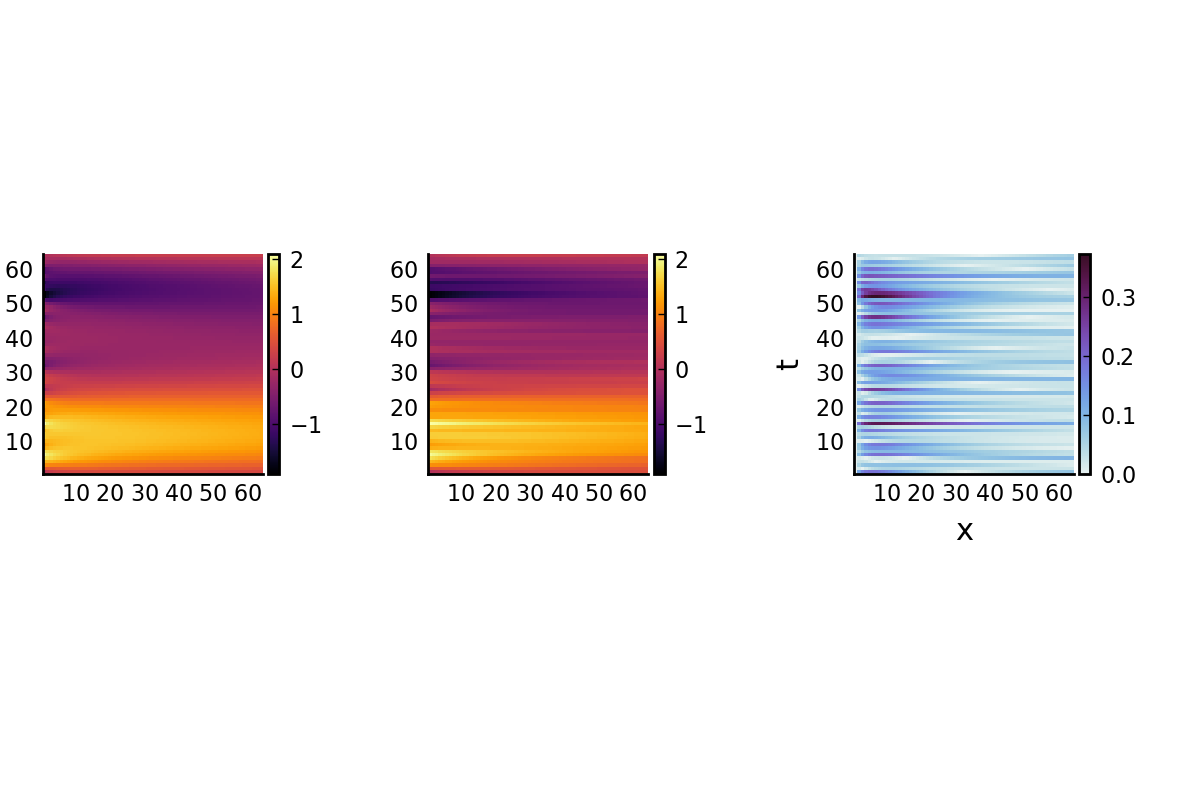

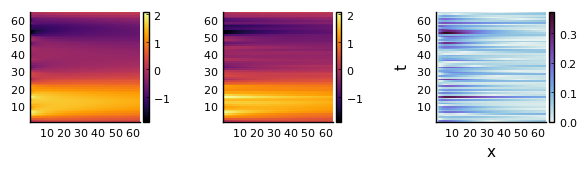

In [39]:
check_result(K, p, 3)

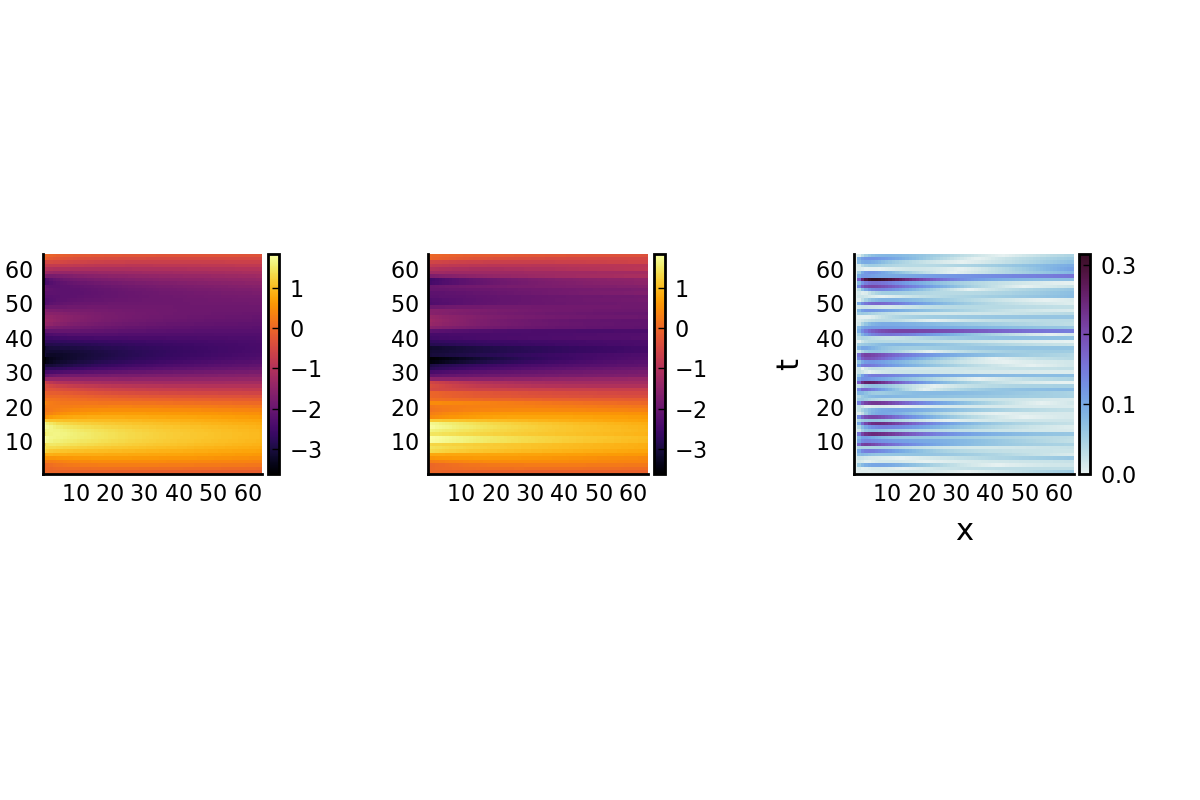

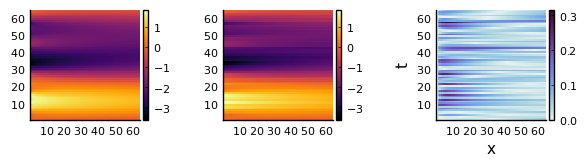

In [41]:
data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, true);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
i = 9
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)

---
## Analysis

### MSE approximated operator

In [42]:
function test_simulation(K, p,  n, typ)
    mse_tot = 0
    l1_tot = 0
    
    for i in 1:n
        t, u0, u_true = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, typ, kappa, k);
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
        u_pred = prob_neuralode(u0, p);
        mse_tot += Flux.mse(u_pred, u_true)
        l1_tot += Flux.mae(u_pred, u_true)
    end
    
    return mse_tot / n, l1_tot / n
end

# test_simulation(K, 100, 3)

test_simulation (generic function with 1 method)

In [43]:
function test_simulation_2(K, p, data, ratio)
    t, init, u = ProcessingTools.process_dataset(data, true);
    t_train, t_val = splitobs(t, at = ratio);
    train_set, val_set = splitobs(u, at = ratio);
    
    n = size(init, 2)
    mse_tot = 0
    l1_tot = 0
    mse_train = 0
    l1_train = 0
    mse_val = 0
    l1_val = 0
    
    for i in 1:n
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
        u0 = init[:, i]
        u_pred = prob_neuralode(u0, p);
        mse_tot += Flux.mse(u_pred, u[:, i, :])
        l1_tot += Flux.mae(u_pred, u[:, i, :])
        
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t_train[1], t_train[end]), Tsit5(), saveat=t_train);
        u0 = init[:, i]
        u_pred = prob_neuralode(u0, p);
        mse_train += Flux.mse(u_pred, train_set[:, i, :])
        l1_train += Flux.mae(u_pred, train_set[:, i, :])
        
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t_val[1], t_val[end]), Tsit5(), saveat=t_val);
        u0 = copy(val_set[:, i, 1]);
        u_pred = prob_neuralode(u0, p);
        mse_val += Flux.mse(u_pred, val_set[:, i, :])
        l1_val += Flux.mae(u_pred, val_set[:, i, :])
    end
    
    return mse_tot / n, l1_tot / n, mse_train / n, l1_train / n, mse_val / n, l1_val / n
end


test_simulation_2 (generic function with 1 method)

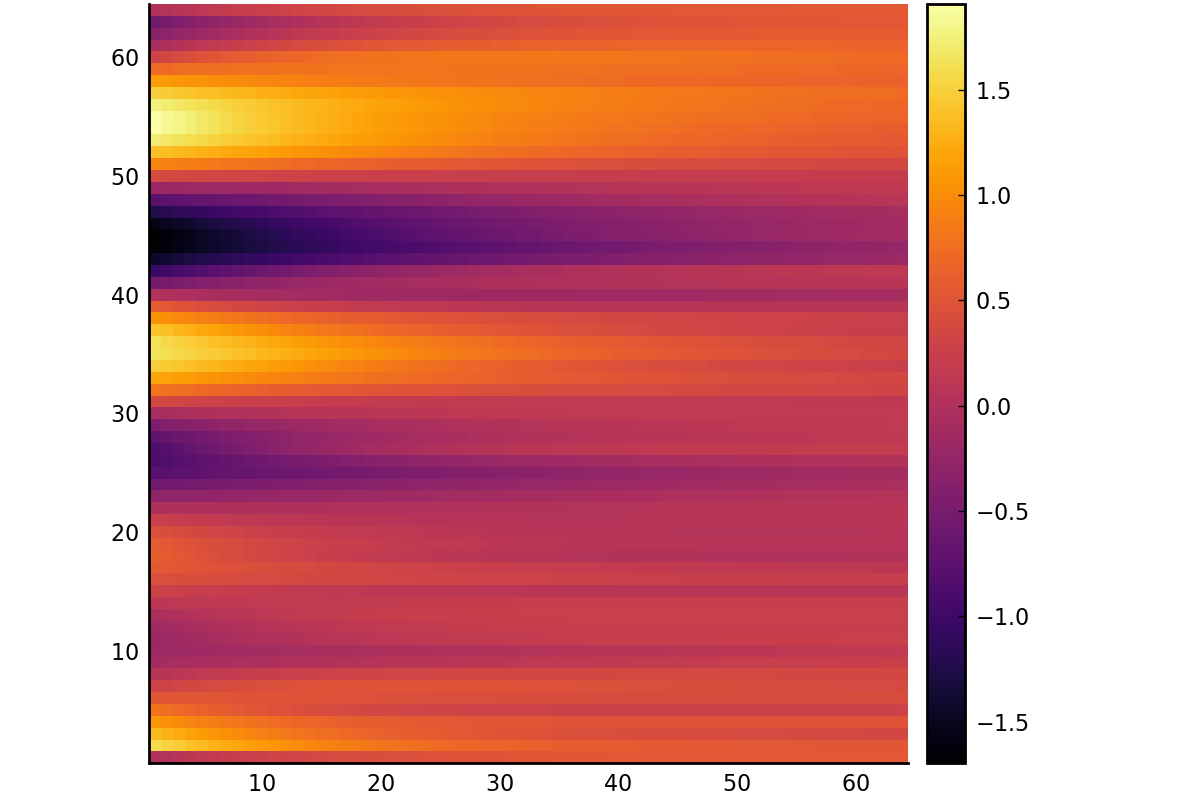

In [48]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, x_n, t_n, 2, kappa);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
u_pred = prob_neuralode(u0, p);

GraphicTools.show_state(hcat(u_pred.u...), "")

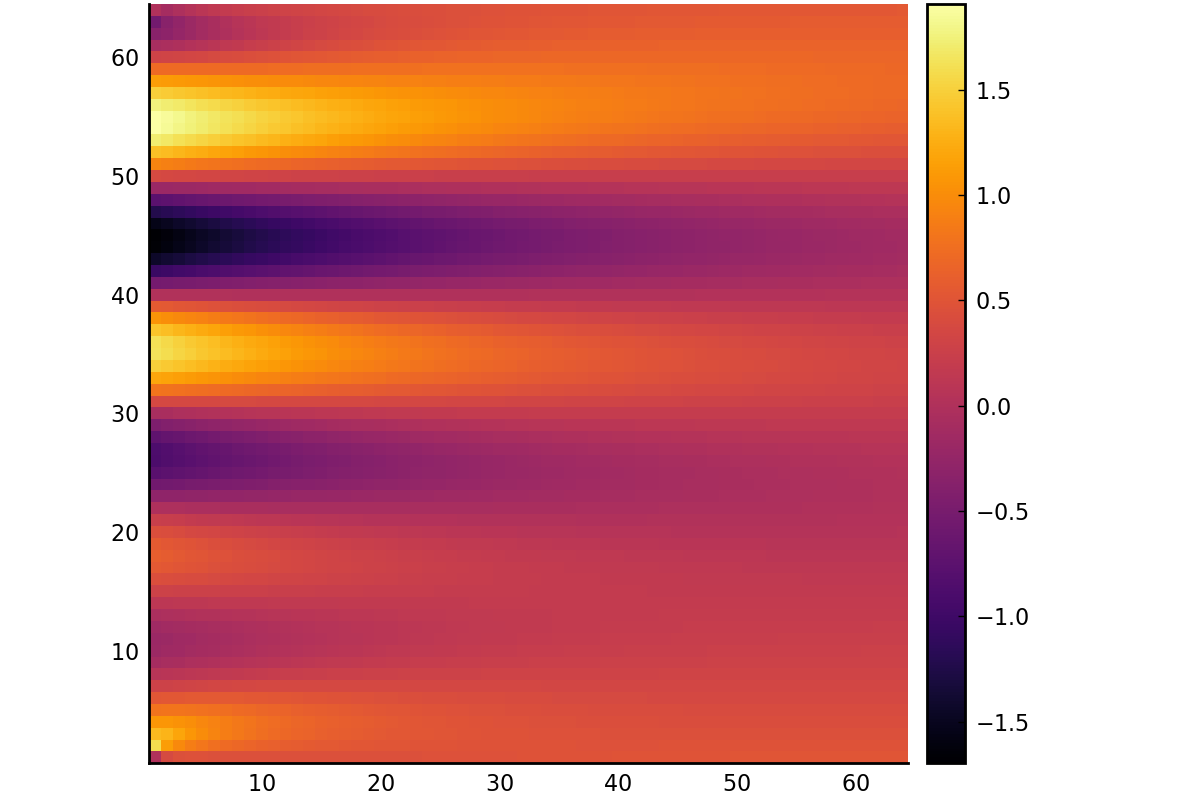

In [49]:
GraphicTools.show_state(u, "")

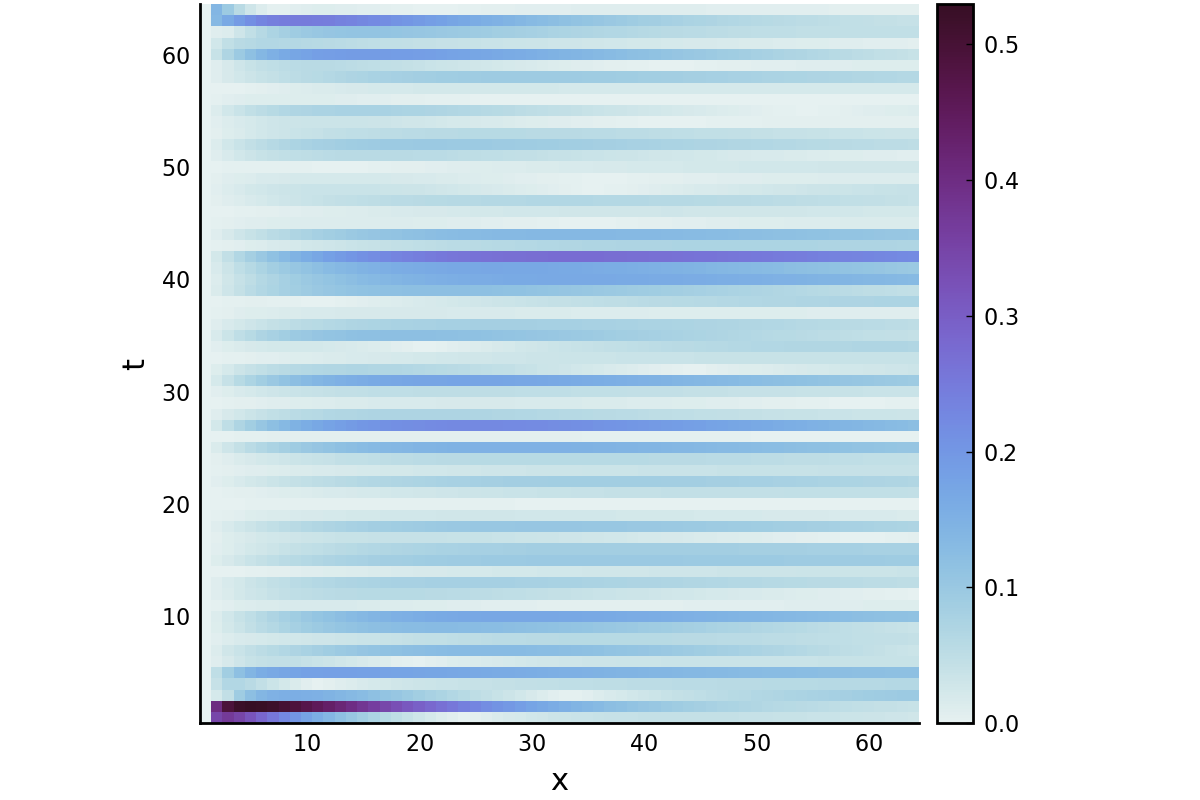

In [50]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

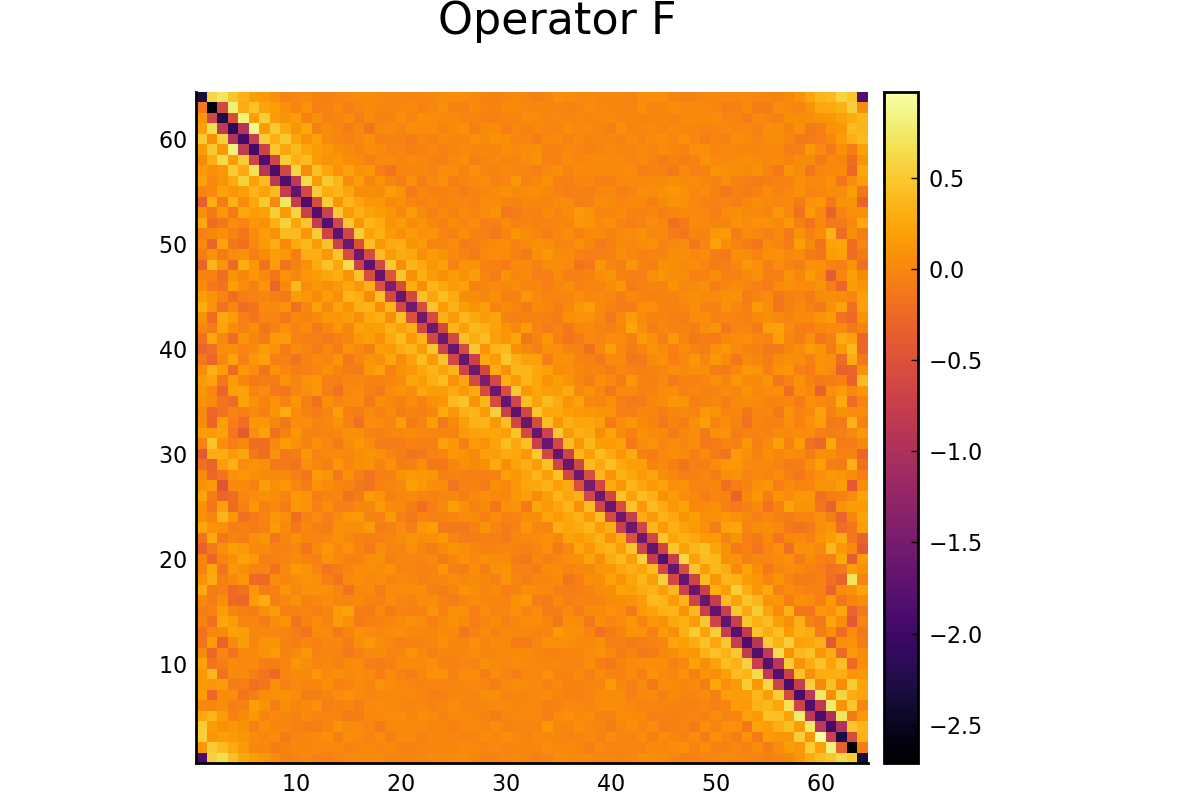

In [51]:
GraphicTools.show_state(reverse(Flux.params(K)[1]; dims = 1), "Operator F")

### Regularization

In [52]:
function analyse_model(files, data, ratio)
    sim = 100
    typ = 2
    mse_inters = []
    mse_sets = []
    mse_trains = []
    mse_vals = []
    
    for filename in files
        @load filename K p
        mse_inter, _ = test_simulation(K, p, sim, typ)
        mse_set, _, mse_train_set, _, mse_val_set, _ = test_simulation_2(K, p, data, ratio)
            
        push!(mse_inters, copy(mse_inter))
        push!(mse_sets, copy(mse_set))
        push!(mse_trains, copy(mse_train_set))
        push!(mse_vals, copy(mse_val_set))
    end

    return mse_inters, mse_sets, mse_trains, mse_vals
end

analyse_model (generic function with 1 method)

In [53]:
function analyse_L2_regularization(noise, reg, batch_size, ratio)
    sim = 100
    typ = 2
    epochs = 1000;
    files = []
    
    data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
    
    for e in noise
        for (i, r) in enumerate(reg)
            model = Models.LinearModel(x_n);
            K, p = training(model, epochs, data, batch_size, 0.7, e, r);
            filename = "HeatLinearModelExperiment_noise_gauss_10p_" * string(i) * ".bson"
            @save filename K p
            push!(files, filename)
        end
    end
    
    mse_inters, mse_sets, mse_trains, mse_vals = analyse_model(files, data, ratio)

    return files, mse_inters, mse_sets, mse_trains, mse_vals
end

analyse_L2_regularization (generic function with 1 method)

In [54]:
files, a, b, c, d = analyse_L2_regularization(0.1, [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 128, 0.7)

LoadError: syntax: extra token "b" after end of expression

In [20]:
data = Generator.read_dataset("./src/examples/heat/odesolver_analytical_heat_training_set.jld2")["training_set"];
files = []
for (i, r) in enumerate([1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    filename = "./src/examples/heat/reg/HeatLinearModelExperiment_noise_gauss_10p_" * string(i) * ".bson"
    push!(files, filename)
end
a, b, c, d = analyse_model(files, data, 0.7)
@save "./src/examples/heat/reg/heat_cost_regularization_noise_gauss_10p.bson" a b c d

In [17]:
function plot_regularization(noise, reg, a, b, c, d)
    plot(dpi=200)
    plot!(reg, a, markershape=:x, label="Interpolation")
    plot!(reg, b, markershape=:x, label="Full")
    plot!(reg, c, markershape=:x, label="Training")
    plot!(reg, d, markershape=:x, label="Validation")
    plot!(xlabel="Regularization", ylabel="Cost", xaxis=:log)
    plot!(xticks=(reg,["1e-12", "1e-10", "1e-8", "1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1"]))
end

plot_regularization (generic function with 1 method)

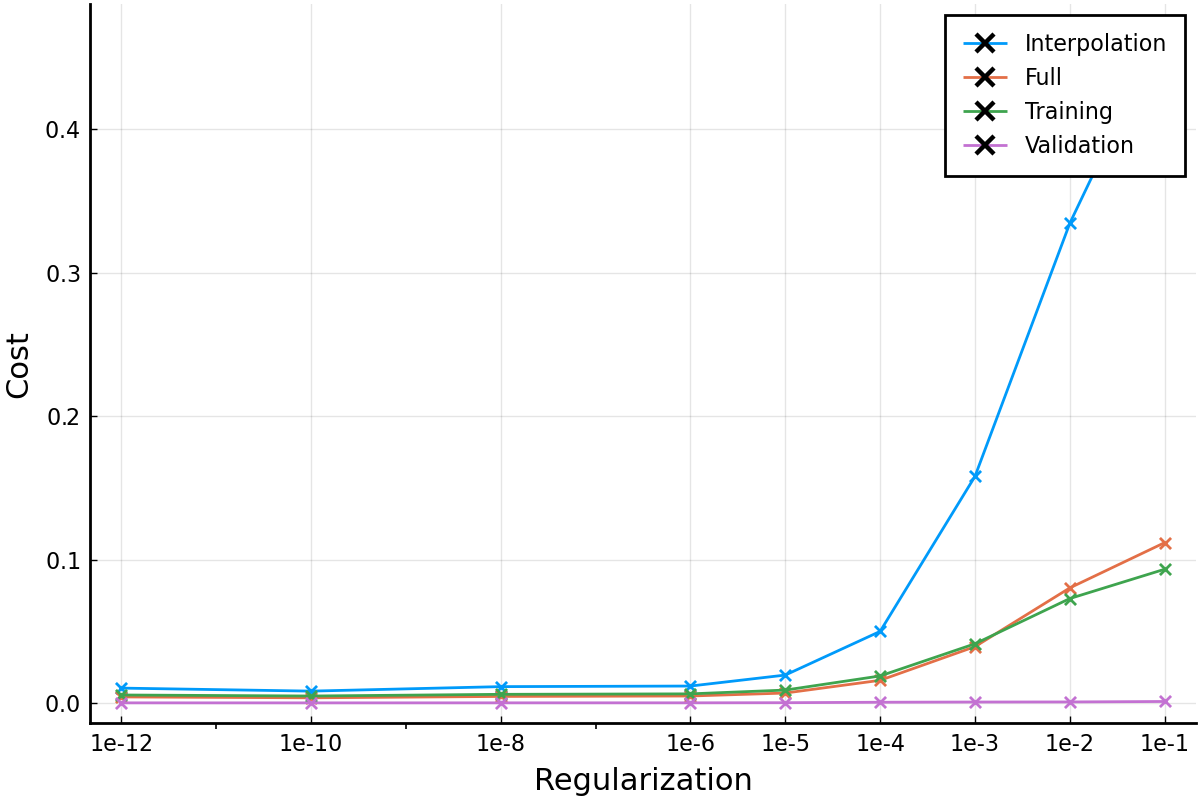

In [153]:
@load "src/examples/heat/reg/heat_cost_regularization_no_noise.bson" a b c d
plot_regularization([0.05], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], a, b, c, d)

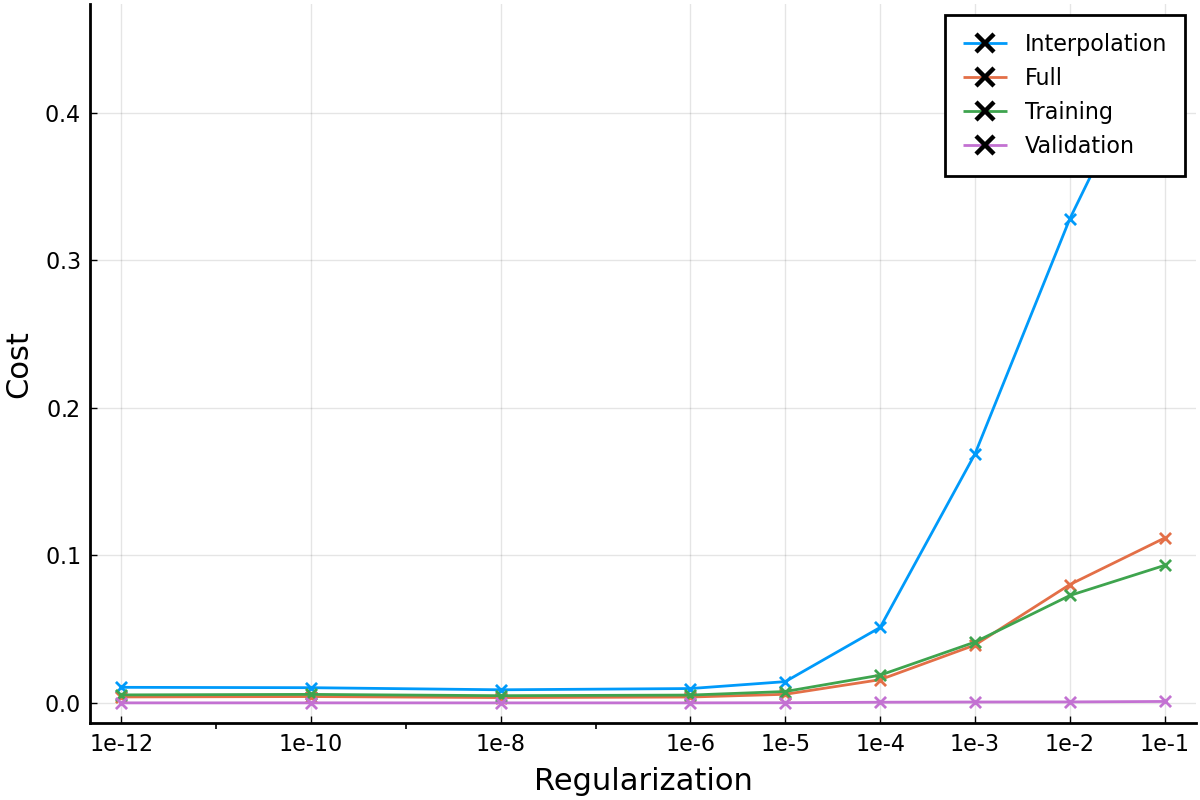

In [134]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_1em5_2.bson" mse_inters mse_sets mse_trains mse_vals
a = mse_inters
b = mse_sets
c = mse_trains
d = mse_vals
plot_regularization([1e-5], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], a, b, c, d)

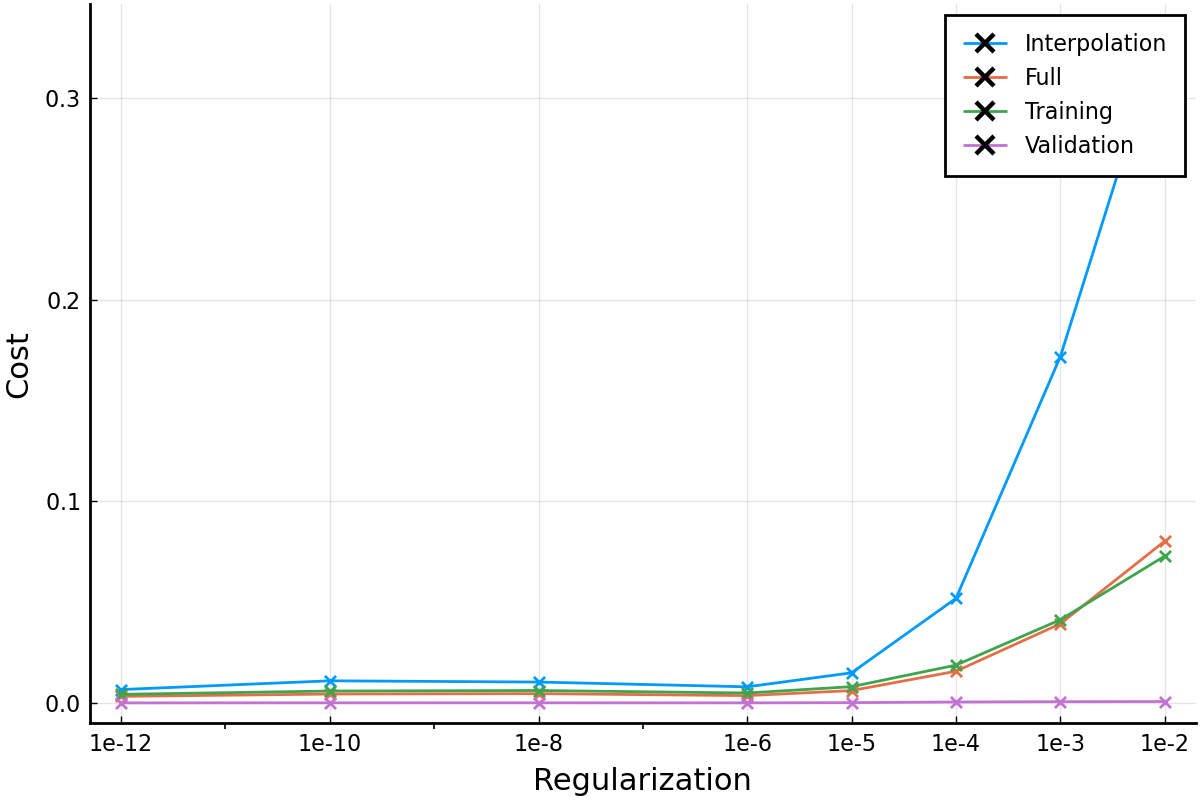

In [130]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_1em3.bson" a b c d
plot_regularization([1e-3], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], a, b, c, d)

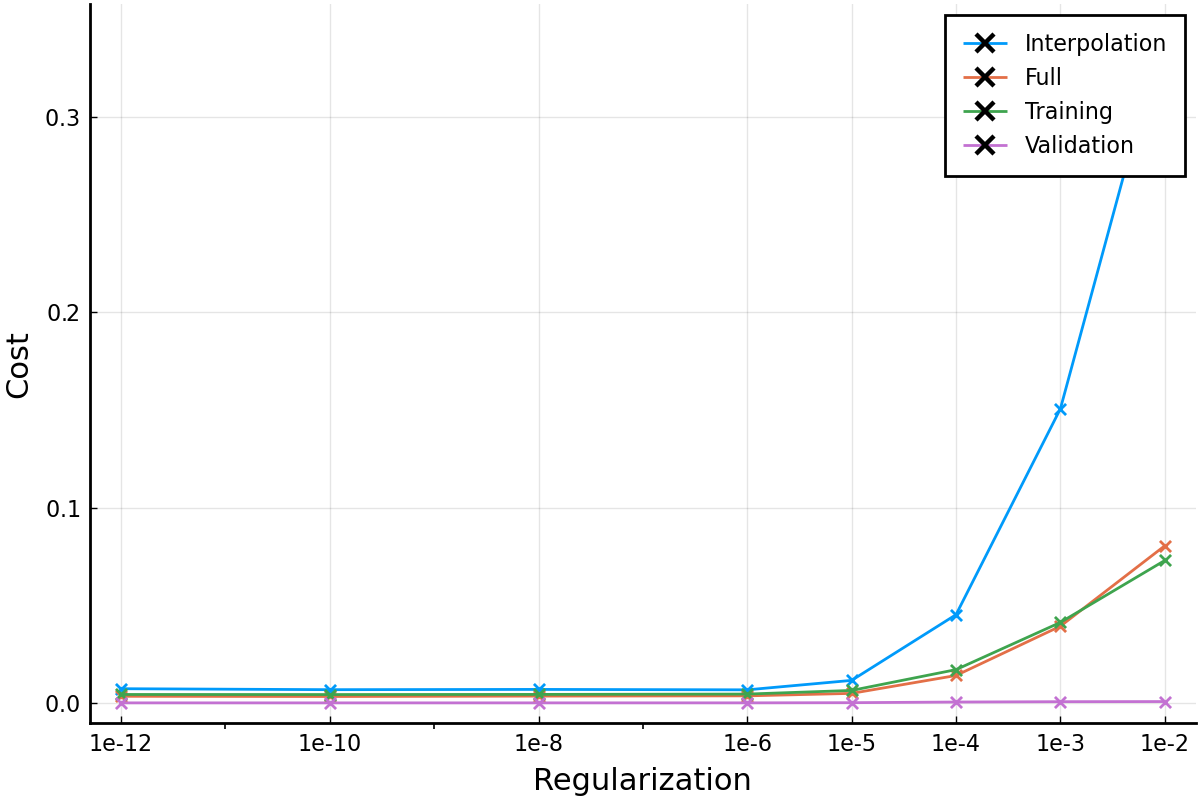

In [129]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_1em1.bson" a b c d
plot_regularization([1e-1], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], a, b, c, d)

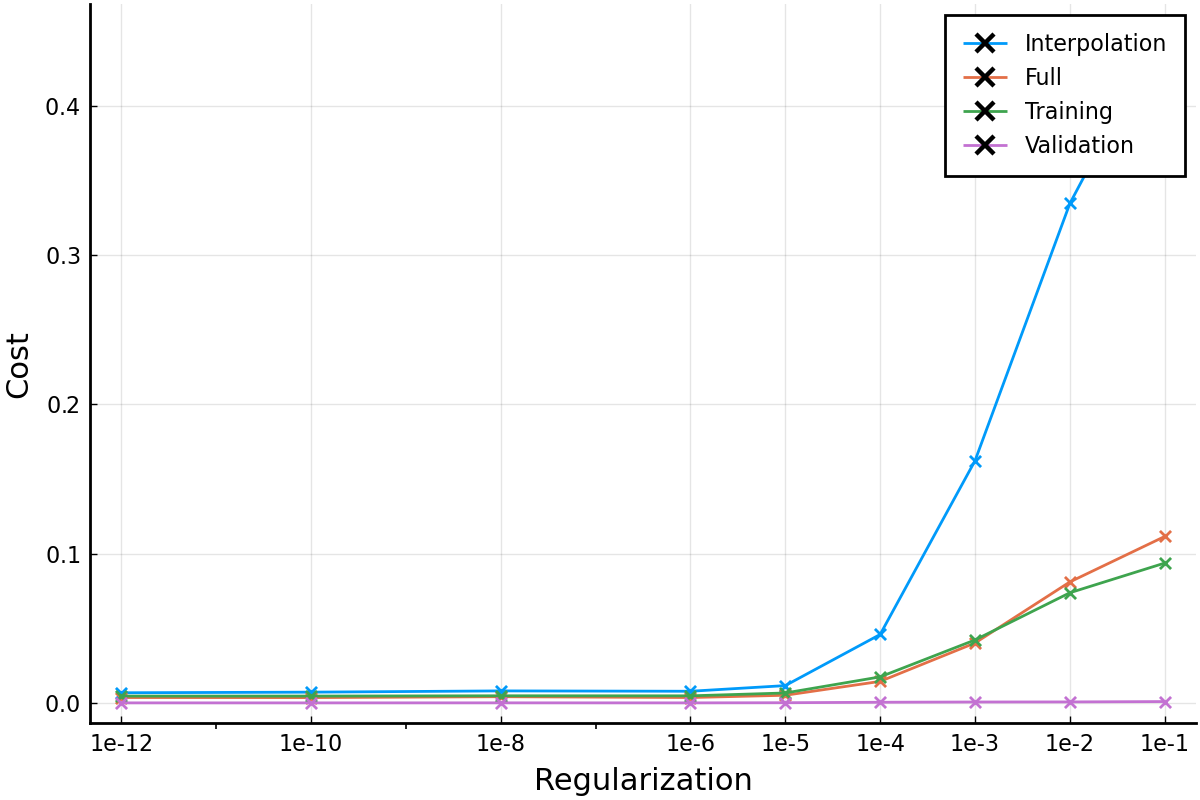

In [24]:
@load "src/examples/heat/reg/heat_cost_regularization_noise_gauss_10p.bson" a b c d
plot_regularization([1e-1], [1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], a, b, c, d)

--- 
### Check L2 regularized model

In [44]:
@load "./src/examples/heat/reg/HeatLinearModelExperiment_noise_gauss_10p_2.bson" K p

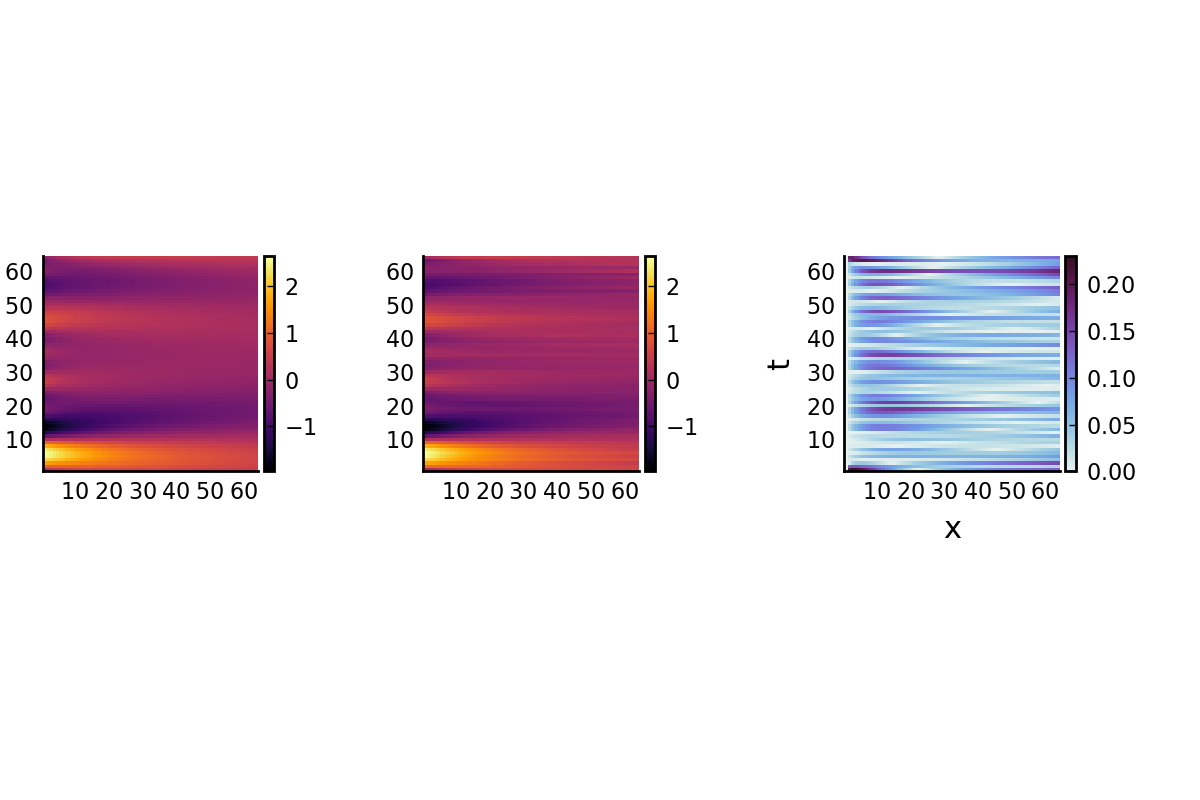

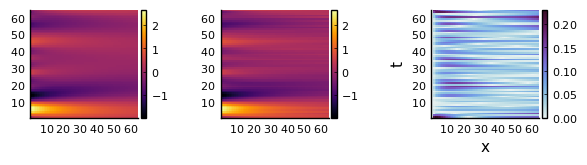

In [45]:
check_result(K, p, 2)